# 02: Phenotype Exploration and Processing

This notebook demonstrates how to load, process, and analyse Cell Painting phenotypic data using ProToPhen. Cell Painting is a high-content imaging assay that captures ~1,500 morphological features per cell, providing a rich phenotypic fingerprint of cellular responses to perturbations.

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Load Cell Painting data** from CellProfiler output or JUMP-CP format
2. **Assess data quality** and identify problematic features
3. **Select informative features** using variance and correlation filtering
4. **Correct batch effects** between plates using robust normalisation
5. **Visualise phenotype space** using UMAP, t-SNE, and heatmaps
6. **Cluster phenotypes** to identify groups of similar cellular responses
7. **Export processed data** for downstream model training

---

## 1. Introduction to Cell Painting

### What is Cell Painting?

[Cell Painting](https://www.nature.com/articles/nprot.2016.105) is a morphological profiling assay that uses six fluorescent dyes to label eight cellular compartments:

| Dye | Target | Compartment |
|-----|--------|-------------|
| Hoechst 33342 | DNA | Nucleus |
| Concanavalin A | ER | Endoplasmic reticulum |
| SYTO 14 | RNA/Nucleoli | Nucleoli, cytoplasmic RNA |
| Phalloidin | F-actin | Actin cytoskeleton |
| Wheat Germ Agglutinin | Golgi/Plasma membrane | Golgi, plasma membrane |
| MitoTracker | Mitochondria | Mitochondria |

### Feature Types (~1,500 morphological features)

CellProfiler extracts features across multiple categories:

- **AreaShape**: Size and shape measurements (area, perimeter, eccentricity, etc.)
- **Intensity**: Fluorescence intensity statistics (mean, std, percentiles)
- **Texture**: Haralick texture features (contrast, entropy, homogeneity)
- **Granularity**: Granularity spectrum features
- **RadialDistribution**: Radial intensity distribution from center
- **Correlation**: Co-localisation between channels
- **Neighbors**: Cell neighborhood features
- **Location**: Spatial position (often removed as batch-dependent)

These features are extracted for three compartments: **Cells** (whole cell), **Cytoplasm**, and **Nuclei**.

### Common Data Formats

1. **CellProfiler Output**: CSV files with one row per cell (or aggregated per well)
2. **JUMP-CP**: Standardised Cell Painting dataset with >136,000 perturbations ([Chandrasekaran et al., 2023](https://www.biorxiv.org/content/10.1101/2023.03.23.534023))

---

## 2. Setup

In [1]:
# Standard library imports
import warnings
from pathlib import Path

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ProToPhen imports
from protophen.data.phenotype import Phenotype, PhenotypeDataset
from protophen.phenotype.cellpainting import (
    CellPaintingProcessor,
    CellPaintingConfig,
    load_cell_painting_data,
    CELLPAINTING_PREFIXES,
    FEATURE_CATEGORIES,
)
from protophen.phenotype.normalisation import (
    Normaliser,
    BatchCorrector,
    FeatureSelector,
    robust_mad_normalise,
    zscore_normalise,
    normalise_plate,
)
from protophen.phenotype.embedding import (
    PhenotypeEmbedder,
    reduce_dimensions,
    get_pca_embedding,
    get_umap_embedding,
)
from protophen.analysis.clustering import (
    PhenotypeClustering,
    ClusteringResult,
    hierarchical_clustering,
    kmeans_clustering,
    hdbscan_clustering,
    cluster_phenotypes,
    compute_cluster_enrichment,
)
from protophen.analysis.visualisation import (
    PlotConfig,
    plot_embedding_space,
    plot_umap,
    plot_tsne,
    plot_pca,
    plot_heatmap,
    plot_correlation_matrix,
    plot_clustermap,
    plot_feature_distributions,
    create_figure_grid,
    save_figure,
)
from protophen.utils.io import ensure_dir, save_embeddings, load_embeddings
from protophen.utils.logging import logger

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore', category=FutureWarning)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("ProToPhen Phenotype Exploration Notebook")
print("=" * 50)

ProToPhen Phenotype Exploration Notebook


### Define Output Directories

In [2]:
# Create output directories
OUTPUT_DIR = Path("outputs/02_phenotype_exploration")
FIGURES_DIR = OUTPUT_DIR / "figures"
DATA_DIR = OUTPUT_DIR / "processed_data"

ensure_dir(FIGURES_DIR)
ensure_dir(DATA_DIR)

print(f"Output directory: {OUTPUT_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"Data directory: {DATA_DIR}")

Output directory: outputs\02_phenotype_exploration
Figures directory: outputs\02_phenotype_exploration\figures
Data directory: outputs\02_phenotype_exploration\processed_data


## 3. Loading Phenotype Data

In this section, we'll demonstrate how to load Cell Painting data. Since you may not have real data available, we'll create **synthetic Cell Painting data** that mimics the structure and characteristics of real CellProfiler output. Once I've had more time to devote to this, I may provide a small test dataset for demonstratory purposes - TBC.

### 3.1 Generate Synthetic Cell Painting Data

We'll create synthetic data with:
- Multiple plates (batch effects)
- Multiple treatments (proteins + controls)
- Realistic feature names and distributions

In [3]:
def generate_synthetic_cell_painting_data(
    n_plates: int = 3,
    wells_per_plate: int = 96,
    n_proteins: int = 20,
    n_features: int = 500,  # Subset for demonstration
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Generate synthetic Cell Painting data for demonstration.
    
    This creates data that mimics real CellProfiler output with:
    - Plate-level batch effects
    - Treatment effects for different proteins
    - Realistic feature distributions
    """
    np.random.seed(random_state)
    
    # Define compartments and feature categories
    compartments = ["Cells", "Cytoplasm", "Nuclei"]
    categories = ["AreaShape", "Intensity", "Texture", "Granularity", "RadialDistribution"]
    
    # Generate feature names
    feature_names = []
    features_per_category = n_features // (len(compartments) * len(categories))
    
    for compartment in compartments:
        for category in categories:
            for i in range(features_per_category):
                feature_names.append(f"{compartment}_{category}_{i:03d}")
    
    n_features = len(feature_names)
    
    # Generate well positions
    rows = "ABCDEFGH"
    cols = range(1, 13)
    well_positions = [f"{r}{c:02d}" for r in rows for c in cols]
    
    # Assign treatments to wells (edge wells = DMSO control)
    def is_edge_well(well: str) -> bool:
        row, col = well[0], int(well[1:])
        return row in "AH" or col in [1, 12]
    
    # Generate protein IDs
    protein_ids = [f"protein_{i:03d}" for i in range(n_proteins)]
    
    records = []
    
    for plate_idx in range(n_plates):
        plate_id = f"plate_{plate_idx:03d}"
        
        # Plate-level batch effect (shift and scale)
        plate_shift = np.random.randn(n_features) * 0.5
        plate_scale = np.random.uniform(0.8, 1.2, n_features)
        
        treatment_idx = 0
        
        for well in well_positions:
            # Determine treatment
            if is_edge_well(well):
                treatment = "DMSO"
                protein_id = None
                # Control wells have baseline phenotype
                base_phenotype = np.zeros(n_features)
            else:
                treatment = protein_ids[treatment_idx % n_proteins]
                protein_id = treatment
                treatment_idx += 1
                
                # Each protein induces a specific phenotype shift
                protein_effect = np.random.randn(n_features) * 0.3
                # Some features are more affected than others
                affected_features = np.random.choice(n_features, size=n_features//5, replace=False)
                protein_effect[affected_features] *= 3
                base_phenotype = protein_effect
            
            # Generate cell count
            cell_count = np.random.randint(100, 500)
            
            # Generate features with noise
            noise = np.random.randn(n_features) * 0.2
            features = (base_phenotype + noise + plate_shift) * plate_scale
            
            # Add some realistic characteristics
            # - AreaShape features should be positive
            # - Intensity features often follow log-normal
            for i, fname in enumerate(feature_names):
                if "AreaShape" in fname:
                    features[i] = np.abs(features[i]) + 10
                elif "Intensity" in fname:
                    features[i] = np.exp(features[i] * 0.5) * 100
            
            # Create record
            record = {
                "Metadata_Plate": plate_id,
                "Metadata_Well": well,
                "Metadata_Sample": f"{plate_id}_{well}",
                "Metadata_Protein": protein_id,
                "Metadata_Treatment": treatment,
                "Metadata_CellCount": cell_count,
            }
            
            # Add features
            for fname, fval in zip(feature_names, features):
                record[fname] = fval
            
            records.append(record)
    
    df = pd.DataFrame(records)
    
    # Add some NaN values (realistic for Cell Painting)
    nan_mask = np.random.random(df[feature_names].shape) < 0.001
    df.loc[:, feature_names] = df[feature_names].mask(nan_mask)
    
    return df, feature_names


# Generate synthetic data
print("Generating synthetic Cell Painting data...")
synthetic_df, feature_names = generate_synthetic_cell_painting_data(
    n_plates=3,
    wells_per_plate=96,
    n_proteins=20,
    n_features=500,
)

print(f"\nDataset shape: {synthetic_df.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Plates: {synthetic_df['Metadata_Plate'].unique().tolist()}")
print(f"Treatments: {synthetic_df['Metadata_Treatment'].nunique()} unique")

Generating synthetic Cell Painting data...

Dataset shape: (288, 501)
Number of features: 495
Plates: ['plate_000', 'plate_001', 'plate_002']
Treatments: 21 unique


In [4]:
# Preview the data
print("Data preview:")
display_cols = ["Metadata_Plate", "Metadata_Well", "Metadata_Treatment", 
                "Metadata_CellCount"] + feature_names[:5]
synthetic_df[display_cols].head(10)

Data preview:


,Metadata_Plate,Metadata_Well,Metadata_Treatment,Metadata_CellCount,Cells_AreaShape_000,Cells_AreaShape_001,Cells_AreaShape_002,Cells_AreaShape_003,Cells_AreaShape_004
0,plate_000,A01,DMSO,158,10.346404,10.137896,10.122208,10.779889,10.257162
1,plate_000,A02,DMSO,141,10.296988,10.023585,10.504541,10.507921,10.462405
2,plate_000,A03,DMSO,412,10.469414,10.072156,10.232692,10.983922,10.529558
3,plate_000,A04,DMSO,478,10.211241,10.152156,10.325071,10.814669,10.112613
4,plate_000,A05,DMSO,482,10.181689,10.008421,10.364388,10.975782,10.021910
5,plate_000,A06,DMSO,153,10.084732,10.069620,10.117156,10.719482,10.152769
6,plate_000,A07,DMSO,286,10.361357,10.148135,10.386027,10.964825,10.358266
7,plate_000,A08,DMSO,261,10.156137,10.067586,10.034597,10.634596,10.219117
8,plate_000,A09,DMSO,186,10.438233,10.021904,10.122722,10.516879,10.002850
9,plate_000,A10,DMSO,210,10.334085,10.356167,10.197402,10.671612,10.069686


### 3.2 Save Synthetic Data for Loading Demo

In [5]:
# Save synthetic data to CSV
synthetic_data_path = DATA_DIR / "synthetic_cell_painting.csv"
synthetic_df.to_csv(synthetic_data_path, index=False)
print(f"Saved synthetic data to: {synthetic_data_path}")

Saved synthetic data to: outputs\02_phenotype_exploration\processed_data\synthetic_cell_painting.csv


### 3.3 Load Data Using CellPaintingProcessor

The `CellPaintingProcessor` class handles loading and initial processing of Cell Painting data:

In [6]:
# Configure the processor
config = CellPaintingConfig(
    compartments=["Cells", "Cytoplasm", "Nuclei"],
    feature_categories=None,  # Use all categories
    remove_blocklist=True,    # Remove location features, etc.
    min_variance=1e-6,
    max_correlation=0.95,
    max_nan_fraction=0.05,
    aggregation_method="median",
    min_cell_count=50,
    sample_id_col="Metadata_Sample",
    protein_id_col="Metadata_Protein",
    well_col="Metadata_Well",
    plate_col="Metadata_Plate",
    cell_count_col="Metadata_CellCount",
)

# Create processor
processor = CellPaintingProcessor(config)
print(f"Processor configuration:")
print(f"  Compartments: {config.compartments}")
print(f"  Min variance: {config.min_variance}")
print(f"  Max correlation: {config.max_correlation}")
print(f"  Min cell count: {config.min_cell_count}")

2026-02-08 22:22:03 | INFO     | protophen.phenotype.cellpainting:__init__:143 | Initialised CellPaintingProcessor


Processor configuration:
  Compartments: ['Cells', 'Cytoplasm', 'Nuclei']
  Min variance: 1e-06
  Max correlation: 0.95
  Min cell count: 50


In [7]:
# Load and process data
# Note: aggregate_wells=False since our synthetic data is already well-level
dataset = processor.process_dataframe(synthetic_df, aggregate_wells=False)

print(f"\nLoaded dataset: {dataset}")
print(f"Number of samples: {len(dataset)}")
print(f"Number of features: {len(processor.feature_names)}")
print(f"QC passed: {sum(1 for p in dataset if p.qc_passed)}/{len(dataset)}")

2026-02-08 22:22:03 | INFO     | protophen.phenotype.cellpainting:process_dataframe:260 | Identified 495 feature columns
2026-02-08 22:22:03 | INFO     | protophen.phenotype.cellpainting:process_dataframe:264 | Retained 495 features after filtering
2026-02-08 22:22:03 | INFO     | protophen.phenotype.cellpainting:process_dataframe:301 | Created dataset with 288 samples



Loaded dataset: PhenotypeDataset(name='cell_painting', n_samples=288)
Number of samples: 288
Number of features: 495
QC passed: 288/288


### 3.4 Alternative: Load Using Convenience Function

In [8]:
# Alternative loading method using convenience function
# dataset_alt = load_cell_painting_data(
#     synthetic_data_path,
#     aggregate_wells=False,
#     min_cell_count=50,
# )

### 3.5 Examine the Phenotype Objects

In [9]:
# Examine a single Phenotype object
sample = dataset[0]
print("Example Phenotype object:")
print(f"  Sample ID: {sample.sample_id}")
print(f"  Protein ID: {sample.protein_id}")
print(f"  Well: {sample.well_id}")
print(f"  Plate: {sample.plate_id}")
print(f"  Cell count: {sample.cell_count}")
print(f"  QC passed: {sample.qc_passed}")
print(f"  N features: {sample.n_features}")
print(f"  Feature vector shape: {sample.features.shape}")
print(f"  Feature range: [{sample.features.min():.2f}, {sample.features.max():.2f}]")

Example Phenotype object:
  Sample ID: plate_000_A01
  Protein ID: nan
  Well: A01
  Plate: plate_000
  Cell count: 158
  QC passed: True
  N features: 495
  Feature vector shape: (495,)
  Feature range: [-1.50, 302.79]


In [10]:
# Get feature matrix for analysis
feature_matrix = dataset.get_feature_matrix(qc_only=True)
metadata_df = dataset.get_metadata_df()

print(f"\nFeature matrix shape: {feature_matrix.shape}")
print(f"Metadata columns: {metadata_df.columns.tolist()}")


Feature matrix shape: (288, 495)
Metadata columns: ['sample_id', 'protein_id', 'well_id', 'plate_id', 'treatment', 'concentration', 'timepoint', 'cell_count', 'qc_passed', 'n_features', 'metadata']


### 3.6 Understanding the PhenotypeDataset

In [11]:
# Get dataset summary
summary = dataset.summary()
print("Dataset Summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")

Dataset Summary:
  name: cell_painting
  n_samples: 288
  n_features: 495
  n_plates: 3
  n_proteins: 21
  n_qc_passed: 288
  feature_stats: {'mean': 23.30036163330078, 'std': 44.63058853149414, 'n_nan': 0}


In [12]:
# Filter by plate
plate_0_data = dataset.filter(lambda p: p.plate_id == "plate_000")
print(f"\nPlate 0 samples: {len(plate_0_data)}")

# Get phenotypes for a specific protein
protein_phenotypes = dataset.get_by_protein_id("protein_001")
print(f"Phenotypes for protein_001: {len(protein_phenotypes)}")


Plate 0 samples: 96
Phenotypes for protein_001: 9


## 4. Data Quality Assessment

Before processing, it's crucial to assess data quality:
- Missing values
- Feature distributions
- Outliers
- Problematic features

### 4.1 Missing Value Analysis

In [13]:
# Analyse missing values
nan_counts = np.isnan(feature_matrix).sum(axis=0)
nan_fractions = nan_counts / feature_matrix.shape[0]

print("Missing Value Analysis:")
print(f"  Total NaN values: {np.isnan(feature_matrix).sum()}")
print(f"  Features with any NaN: {(nan_counts > 0).sum()}")
print(f"  Max NaN fraction: {nan_fractions.max():.4f}")

Missing Value Analysis:
  Total NaN values: 0
  Features with any NaN: 0
  Max NaN fraction: 0.0000


2026-02-08 22:22:03 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\missing_values.png


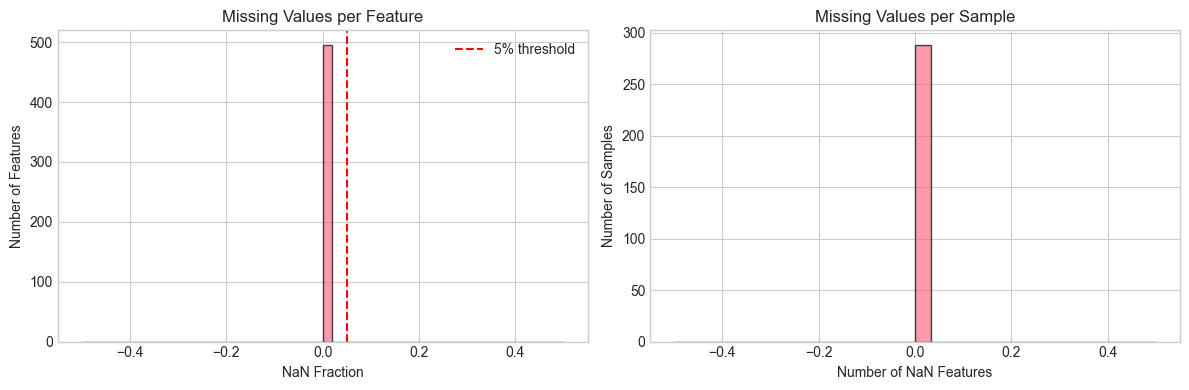

In [14]:
# Plot missing value distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of NaN fractions per feature
axes[0].hist(nan_fractions, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.05, color='red', linestyle='--', label='5% threshold')
axes[0].set_xlabel('NaN Fraction')
axes[0].set_ylabel('Number of Features')
axes[0].set_title('Missing Values per Feature')
axes[0].legend()

# NaN counts per sample
nan_per_sample = np.isnan(feature_matrix).sum(axis=1)
axes[1].hist(nan_per_sample, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of NaN Features')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Missing Values per Sample')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "missing_values.png")
plt.show()

### 4.2 Feature Statistics

In [15]:
# Compute feature statistics
feature_stats = pd.DataFrame({
    'feature': processor.feature_names,
    'mean': np.nanmean(feature_matrix, axis=0),
    'std': np.nanstd(feature_matrix, axis=0),
    'min': np.nanmin(feature_matrix, axis=0),
    'max': np.nanmax(feature_matrix, axis=0),
    'median': np.nanmedian(feature_matrix, axis=0),
    'nan_fraction': nan_fractions,
})

# Add variance
feature_stats['variance'] = feature_stats['std'] ** 2

# Add coefficient of variation
feature_stats['cv'] = feature_stats['std'] / np.abs(feature_stats['mean'] + 1e-10)

print("Feature Statistics Summary:")
print(feature_stats.describe())

Feature Statistics Summary:
             mean         std         min         max      median  \
count  495.000000  495.000000  495.000000  495.000000  495.000000   
mean    23.300362    6.783354    6.367478   63.958885   22.485687   
std     42.118526   13.260620   14.748838  127.050636   40.502899   
min     -0.676907    0.253909   -4.537216    0.890086   -0.740658   
25%     -0.072773    0.469817   -2.193382    1.891468   -0.047284   
50%      0.252015    0.572431   -1.553810    2.625292    0.289574   
75%     10.594594    0.801830   10.001383   12.772600   10.495220   
max    159.914764   91.849495   60.557327  744.914124  143.318344   

       nan_fraction     variance          cv  
count         495.0   495.000000  495.000000  
mean            0.0   221.502701    5.898440  
std             0.0   607.154175   22.946911  
min             0.0     0.064470    0.024689  
25%             0.0     0.220730    0.244713  
50%             0.0     0.327678    1.428290  
75%             0.0  

In [16]:
# Identify features by category
def get_feature_category(feature_name: str) -> str:
    """Extract category from feature name."""
    for category in FEATURE_CATEGORIES:
        if category in feature_name:
            return category
    return "Other"

feature_stats['category'] = feature_stats['feature'].apply(get_feature_category)

# Count features per category
category_counts = feature_stats['category'].value_counts()
print("\nFeatures per category:")
print(category_counts)


Features per category:
category
AreaShape             99
Intensity             99
Texture               99
Granularity           99
RadialDistribution    99
Name: count, dtype: int64


C:\Users\adou0002\AppData\Local\Temp\ipykernel_30804\2541835320.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
C:\Users\adou0002\AppData\Local\Temp\ipykernel_30804\2541835320.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
C:\Users\adou0002\AppData\Local\Temp\ipykernel_30804\2541835320.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
C:\Users\adou0002\AppData\Local\Temp\ipykernel_30804\2541835320.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i

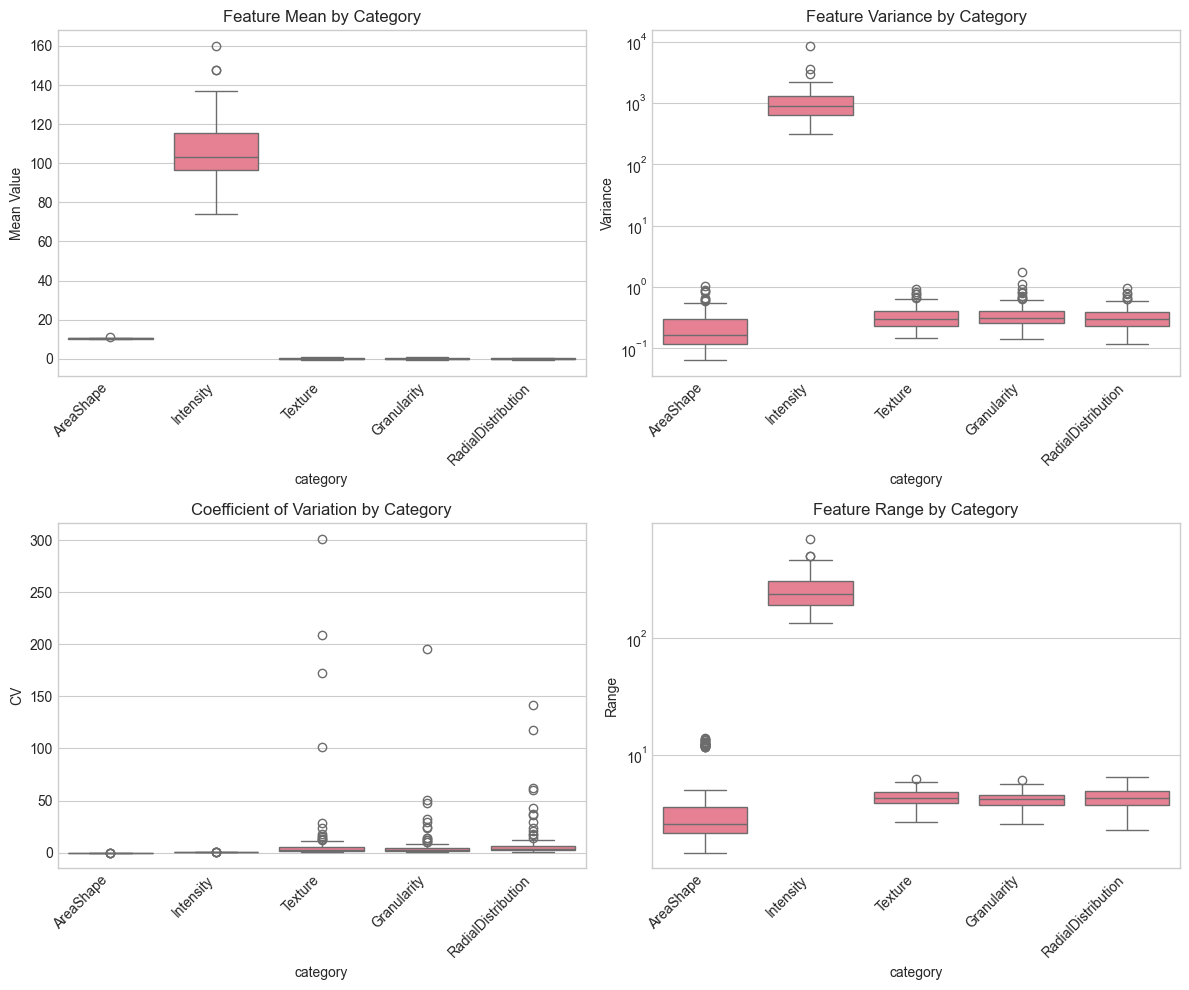

In [17]:
# Plot feature statistics by category
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Mean by category
sns.boxplot(data=feature_stats, x='category', y='mean', ax=axes[0, 0])
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].set_title('Feature Mean by Category')
axes[0, 0].set_ylabel('Mean Value')

# Variance by category
sns.boxplot(data=feature_stats, x='category', y='variance', ax=axes[0, 1])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].set_title('Feature Variance by Category')
axes[0, 1].set_ylabel('Variance')
axes[0, 1].set_yscale('log')

# CV by category
sns.boxplot(data=feature_stats, x='category', y='cv', ax=axes[1, 0])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].set_title('Coefficient of Variation by Category')
axes[1, 0].set_ylabel('CV')

# Feature range by category
feature_stats['range'] = feature_stats['max'] - feature_stats['min']
sns.boxplot(data=feature_stats, x='category', y='range', ax=axes[1, 1])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].set_title('Feature Range by Category')
axes[1, 1].set_ylabel('Range')
axes[1, 1].set_yscale('log')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "feature_statistics.png")
plt.show()

### 4.3 Identify Problematic Features

In [18]:
# Identify potentially problematic features
print("Problematic Feature Analysis:")
print("=" * 50)

# Low variance features
low_var_threshold = 1e-6
low_var_features = feature_stats[feature_stats['variance'] < low_var_threshold]
print(f"\n1. Low variance features (var < {low_var_threshold}):")
print(f"   Count: {len(low_var_features)}")

# High NaN features
high_nan_features = feature_stats[feature_stats['nan_fraction'] > 0.05]
print(f"\n2. High NaN features (>5% missing):")
print(f"   Count: {len(high_nan_features)}")

# Features with extreme values
extreme_features = feature_stats[
    (feature_stats['max'] > feature_stats['mean'] + 10 * feature_stats['std']) |
    (feature_stats['min'] < feature_stats['mean'] - 10 * feature_stats['std'])
]
print(f"\n3. Features with extreme outliers:")
print(f"   Count: {len(extreme_features)}")

# Constant features (all same value)
constant_features = feature_stats[feature_stats['std'] == 0]
print(f"\n4. Constant features:")
print(f"   Count: {len(constant_features)}")

Problematic Feature Analysis:

1. Low variance features (var < 1e-06):
   Count: 0

2. High NaN features (>5% missing):
   Count: 0

3. Features with extreme outliers:
   Count: 26

4. Constant features:
   Count: 0


## 5. Feature Selection

Feature selection is critical for Cell Painting data to:
- Remove uninformative features (low variance)
- Remove redundant features (high correlation)
- Reduce noise and computational burden

### 5.1 Using FeatureSelector Class

In [19]:
# Create feature selector
selector = FeatureSelector(
    min_variance=1e-6,
    max_correlation=0.95,
    max_nan_fraction=0.05,
)

print("Feature Selection Configuration:")
print(f"  Min variance: {selector.min_variance}")
print(f"  Max correlation: {selector.max_correlation}")
print(f"  Max NaN fraction: {selector.max_nan_fraction}")

Feature Selection Configuration:
  Min variance: 1e-06
  Max correlation: 0.95
  Max NaN fraction: 0.05


In [20]:
# Fit and transform
features_selected = selector.fit_transform(feature_matrix)

print(f"\nFeature Selection Results:")
print(f"  Original features: {feature_matrix.shape[1]}")
print(f"  Selected features: {selector.n_selected_}")
print(f"  Removed features: {selector.n_removed_}")
print(f"  Reduction: {100 * selector.n_removed_ / feature_matrix.shape[1]:.1f}%")

2026-02-08 22:22:05 | INFO     | protophen.phenotype.normalisation:fit:566 | Selected 495 of 495 features



Feature Selection Results:
  Original features: 495
  Selected features: 495
  Removed features: 0
  Reduction: 0.0%


In [21]:
# Examine removal reasons
removal_summary = selector.get_removal_summary()
if len(removal_summary) > 0:
    print("\nRemoval reasons:")
    print(removal_summary['reason'].value_counts())

In [22]:
# Get selected feature names
selected_feature_names = [processor.feature_names[i] for i in selector.selected_indices_]
print(f"\nSelected feature categories:")
selected_categories = [get_feature_category(f) for f in selected_feature_names]
print(pd.Series(selected_categories).value_counts())


Selected feature categories:
AreaShape             99
Intensity             99
Texture               99
Granularity           99
RadialDistribution    99
Name: count, dtype: int64


### 5.2 Manual Feature Selection Strategies

You can also implement custom feature selection:

In [23]:
def select_features_manual(
    features: np.ndarray,
    feature_names: list,
    min_variance: float = 1e-6,
    max_correlation: float = 0.95,
) -> tuple:
    """
    Manual feature selection with detailed logging.
    """
    n_original = features.shape[1]
    selected_mask = np.ones(n_original, dtype=bool)
    
    # Step 1: Variance filtering
    variances = np.nanvar(features, axis=0)
    low_var_mask = variances < min_variance
    selected_mask &= ~low_var_mask
    print(f"Step 1 - Variance filter: removed {low_var_mask.sum()} features")
    
    # Step 2: Correlation filtering
    remaining_indices = np.where(selected_mask)[0]
    features_remaining = features[:, remaining_indices]
    
    # Compute correlation matrix
    df_temp = pd.DataFrame(features_remaining)
    corr_matrix = df_temp.corr().abs().values
    
    # Find highly correlated pairs
    corr_removed = set()
    for i in range(len(remaining_indices)):
        if i in corr_removed:
            continue
        for j in range(i + 1, len(remaining_indices)):
            if j in corr_removed:
                continue
            if corr_matrix[i, j] > max_correlation:
                # Remove feature with lower variance
                var_i = variances[remaining_indices[i]]
                var_j = variances[remaining_indices[j]]
                remove_idx = j if var_i >= var_j else i
                corr_removed.add(remove_idx)
    
    # Update mask
    for local_idx in corr_removed:
        global_idx = remaining_indices[local_idx]
        selected_mask[global_idx] = False
    
    print(f"Step 2 - Correlation filter: removed {len(corr_removed)} features")
    
    # Get final selection
    selected_indices = np.where(selected_mask)[0]
    selected_names = [feature_names[i] for i in selected_indices]
    
    print(f"\nTotal: {n_original} → {len(selected_indices)} features")
    
    return selected_indices, selected_names

# Demo manual selection (already done above, so just showing the function)
print("Manual feature selection function defined.")

Manual feature selection function defined.


## 6. Batch Correction

Batch effects are systematic technical variations between plates that can confound biological signal. Common sources include:
- Different imaging sessions
- Plate position effects
- Staining intensity variations
- Temperature/humidity differences

### 6.1 Visualise Batch Effects

2026-02-08 22:22:05 | INFO     | protophen.phenotype.embedding:__init__:129 | Initialised PhenotypeEmbedder: method=pca, n_components=2
2026-02-08 22:22:05 | INFO     | protophen.phenotype.embedding:fit_transform:244 | Fitted and transformed with PCA
2026-02-08 22:22:05 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\batch_effects_raw.png


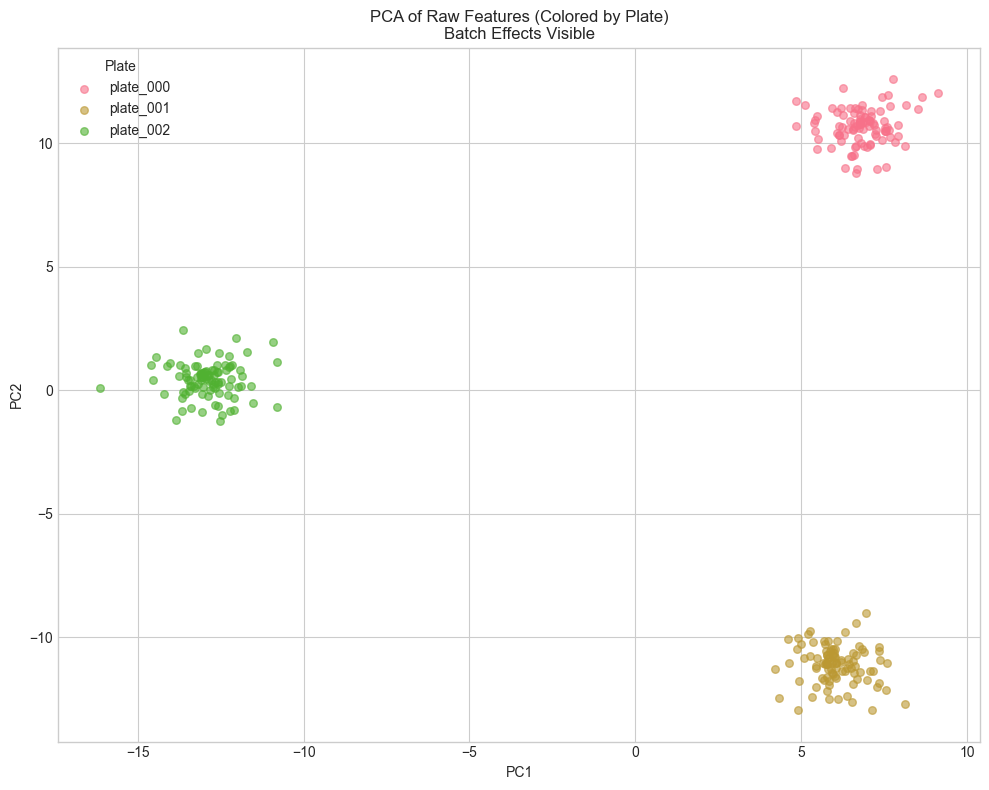

In [24]:
# Extract plate labels
plate_labels = metadata_df['plate_id'].values

# Perform PCA on raw data
pca_raw = PhenotypeEmbedder(method="pca", n_components=2)
coords_raw = pca_raw.fit_transform(features_selected)

# Plot raw data colored by plate
fig, ax = plt.subplots(figsize=(10, 8))

for plate in np.unique(plate_labels):
    mask = plate_labels == plate
    ax.scatter(
        coords_raw[mask, 0],
        coords_raw[mask, 1],
        label=plate,
        alpha=0.6,
        s=30,
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA of Raw Features (Colored by Plate)\nBatch Effects Visible')
ax.legend(title='Plate')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "batch_effects_raw.png")
plt.show()

### 6.2 Apply Batch Correction with BatchCorrector

In [25]:
# Create batch corrector
batch_corrector = BatchCorrector(method="robust")

print("Batch Correction Configuration:")
print(f"  Method: {batch_corrector.method}")

Batch Correction Configuration:
  Method: robust


In [26]:
# Fit and transform
features_corrected = batch_corrector.fit_transform(features_selected, plate_labels)

print(f"\nBatch correction applied.")
print(f"Feature matrix shape: {features_corrected.shape}")

2026-02-08 22:22:06 | INFO     | protophen.phenotype.normalisation:fit:355 | Fitted BatchCorrector on 3 batches



Batch correction applied.
Feature matrix shape: (288, 495)


In [27]:
# View batch statistics
batch_summary = batch_corrector.get_batch_summary()
print("\nBatch Statistics:")
batch_summary


Batch Statistics:


,batch,n_samples,center_mean,center_std,scale_mean,scale_std
0,plate_000,96,23.064272,43.162968,3.321100,6.493433
1,plate_001,96,22.744524,41.905914,3.274090,6.253694
2,plate_002,96,22.660910,41.435753,3.384406,6.517421


### 6.3 Visualise Corrected Data

2026-02-08 22:22:06 | INFO     | protophen.phenotype.embedding:__init__:129 | Initialised PhenotypeEmbedder: method=pca, n_components=2
2026-02-08 22:22:06 | INFO     | protophen.phenotype.embedding:fit_transform:244 | Fitted and transformed with PCA
2026-02-08 22:22:06 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\batch_correction_comparison.png


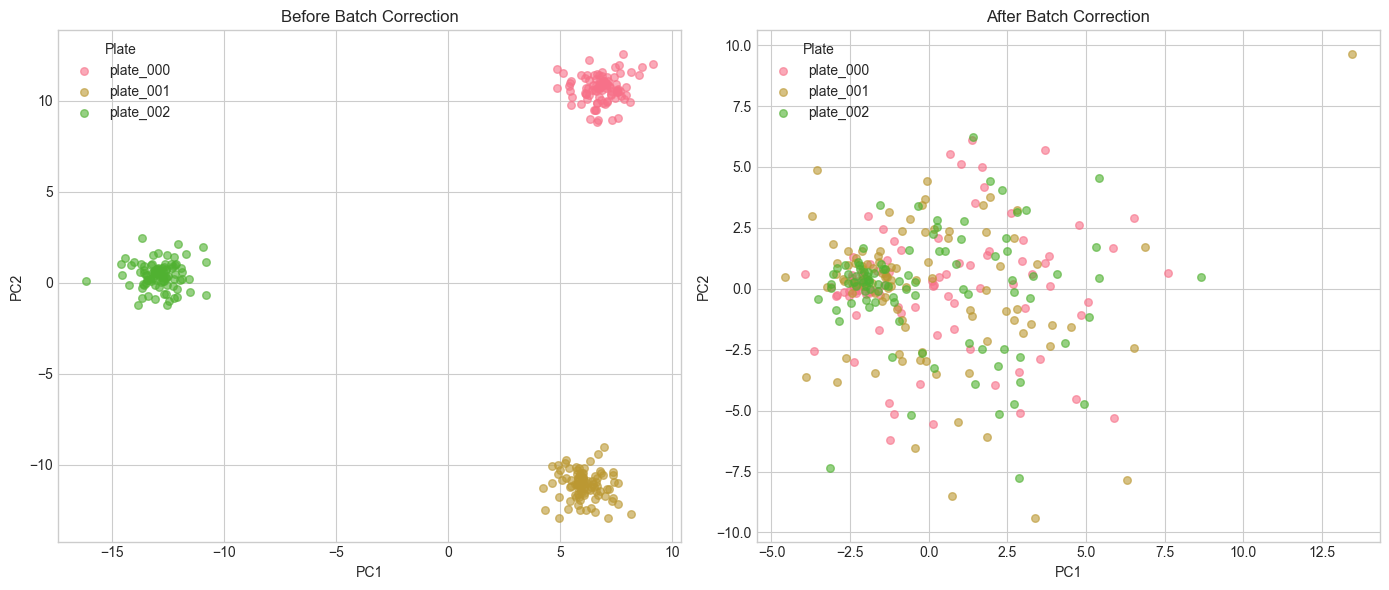

In [28]:
# PCA on corrected data
pca_corrected = PhenotypeEmbedder(method="pca", n_components=2)
coords_corrected = pca_corrected.fit_transform(features_corrected)

# Compare before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before correction
for plate in np.unique(plate_labels):
    mask = plate_labels == plate
    axes[0].scatter(coords_raw[mask, 0], coords_raw[mask, 1], 
                    label=plate, alpha=0.6, s=30)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Before Batch Correction')
axes[0].legend(title='Plate')

# After correction
for plate in np.unique(plate_labels):
    mask = plate_labels == plate
    axes[1].scatter(coords_corrected[mask, 0], coords_corrected[mask, 1], 
                    label=plate, alpha=0.6, s=30)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('After Batch Correction')
axes[1].legend(title='Plate')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "batch_correction_comparison.png")
plt.show()

### 6.4 Plate-Level Normalisation

For finer control, you can normalise plate-by-plate:

In [29]:
# Normalise each plate separately using DMSO controls
def get_control_indices(metadata: pd.DataFrame, plate: str) -> np.ndarray:
    """Get indices of DMSO controls for a plate."""
    mask = (metadata['plate_id'] == plate) & (metadata['treatment'] == 'DMSO')
    plate_mask = metadata['plate_id'] == plate
    # Get local indices within the plate
    plate_indices = np.where(plate_mask)[0]
    control_indices_global = np.where(mask)[0]
    # Convert to local indices
    return np.array([np.where(plate_indices == idx)[0][0] 
                     for idx in control_indices_global 
                     if idx in plate_indices])

# Apply plate-wise normalisation with controls
features_plate_norm = np.zeros_like(features_selected)

# Note: metadata_df needs 'treatment' column
metadata_df['treatment'] = synthetic_df['Metadata_Treatment'].values

for plate in np.unique(plate_labels):
    plate_mask = plate_labels == plate
    plate_features = features_selected[plate_mask]
    
    # Get control indices for this plate
    plate_metadata = metadata_df[plate_mask].reset_index(drop=True)
    control_mask = plate_metadata['treatment'] == 'DMSO'
    control_indices = np.where(control_mask)[0]
    
    # Normalise using controls
    if len(control_indices) > 0:
        normalised = normalise_plate(
            plate_features,
            control_indices=control_indices,
            method="robust_mad",
        )
    else:
        normalised = normalise_plate(plate_features, method="robust_mad")
    
    features_plate_norm[plate_mask] = normalised

print("Plate-level normalisation with DMSO controls complete.")

Plate-level normalisation with DMSO controls complete.


## 7. Normalisation

Beyond batch correction, feature normalisation ensures features are on comparable scales.

### 7.1 Normaliser Class

In [30]:
# Create normaliser with different methods
print("Normalisation Methods Comparison:")
print("=" * 50)

methods = ["robust_mad", "zscore", "minmax"]
normalised_results = {}

for method in methods:
    normaliser = Normaliser(
        method=method,
        clip_outliers=True,
        outlier_threshold=5.0,
    )
    
    normalised = normaliser.fit_transform(features_corrected)
    normalised_results[method] = normalised
    
    print(f"\n{method.upper()}:")
    print(f"  Mean: {normalised.mean():.4f}")
    print(f"  Std: {normalised.std():.4f}")
    print(f"  Range: [{normalised.min():.2f}, {normalised.max():.2f}]")

Normalisation Methods Comparison:

ROBUST_MAD:
  Mean: 0.0679
  Std: 1.3425
  Range: [-5.00, 5.00]

ZSCORE:
  Mean: -0.0004
  Std: 0.9650
  Range: [-5.00, 5.00]

MINMAX:
  Mean: 0.4404
  Std: 0.1957
  Range: [0.00, 1.00]


2026-02-08 22:22:07 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\normalisation_comparison.png


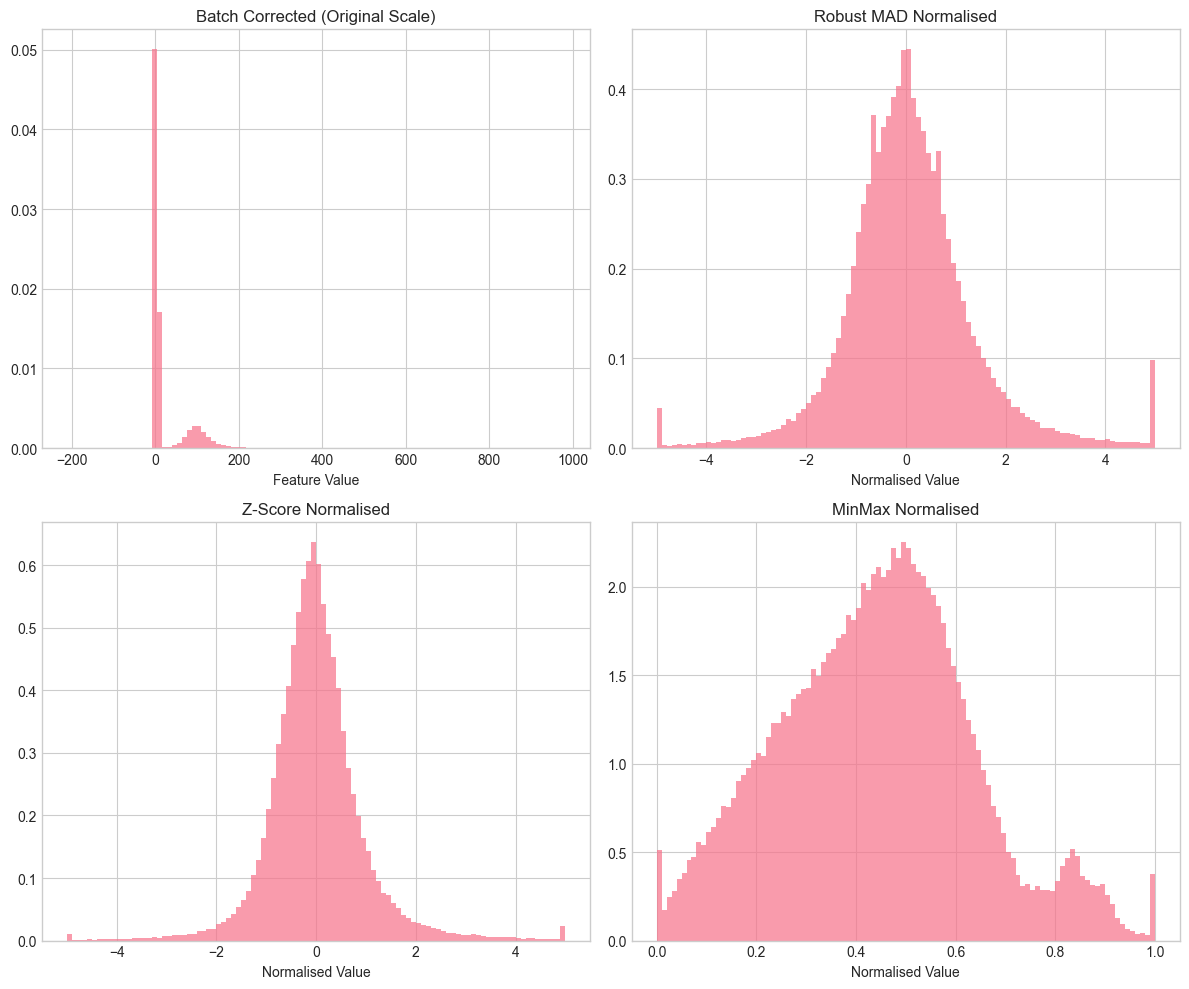

In [31]:
# Visualise normalisation effects
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original (batch-corrected) distribution
axes[0, 0].hist(features_corrected.flatten(), bins=100, alpha=0.7, density=True)
axes[0, 0].set_title('Batch Corrected (Original Scale)')
axes[0, 0].set_xlabel('Feature Value')

# Robust MAD normalised
axes[0, 1].hist(normalised_results['robust_mad'].flatten(), bins=100, alpha=0.7, density=True)
axes[0, 1].set_title('Robust MAD Normalised')
axes[0, 1].set_xlabel('Normalised Value')

# Z-score normalised
axes[1, 0].hist(normalised_results['zscore'].flatten(), bins=100, alpha=0.7, density=True)
axes[1, 0].set_title('Z-Score Normalised')
axes[1, 0].set_xlabel('Normalised Value')

# MinMax normalised
axes[1, 1].hist(normalised_results['minmax'].flatten(), bins=100, alpha=0.7, density=True)
axes[1, 1].set_title('MinMax Normalised')
axes[1, 1].set_xlabel('Normalised Value')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "normalisation_comparison.png")
plt.show()

### 7.2 Select Final Normalised Features

In [32]:
# Use robust MAD normalised features for downstream analysis
features_final = normalised_results['robust_mad']
print(f"Final feature matrix shape: {features_final.shape}")

Final feature matrix shape: (288, 495)


### 7.3 Percent of Control Normalisation

A common alternative in drug screening is to express features as percent of negative control:

In [33]:
def percent_of_control_normalisation(
    features: np.ndarray,
    control_mask: np.ndarray,
) -> np.ndarray:
    """
    Normalise features as percent of control mean.
    
    Args:
        features: Feature matrix (n_samples, n_features)
        control_mask: Boolean mask for control samples
        
    Returns:
        Normalised features as percent of control
    """
    control_mean = features[control_mask].mean(axis=0)
    control_mean = np.where(np.abs(control_mean) < 1e-10, 1e-10, control_mean)
    return (features / control_mean) * 100

# Apply percent of control normalisation
control_mask = metadata_df['treatment'] == 'DMSO'
features_poc = percent_of_control_normalisation(features_corrected, control_mask.values)

print("Percent of Control Normalisation:")
print(f"  Control samples: {control_mask.sum()}")
print(f"  Mean (controls): {features_poc[control_mask].mean():.1f}%")
print(f"  Mean (treatments): {features_poc[~control_mask].mean():.1f}%")

Percent of Control Normalisation:
  Control samples: 108
  Mean (controls): 100.0%
  Mean (treatments): 118.1%


## 8. Visualisation

Visualisation is essential for understanding phenotype space structure and identifying patterns.

### 8.1 Feature Distributions

2026-02-08 22:22:09 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\feature_distributions.png


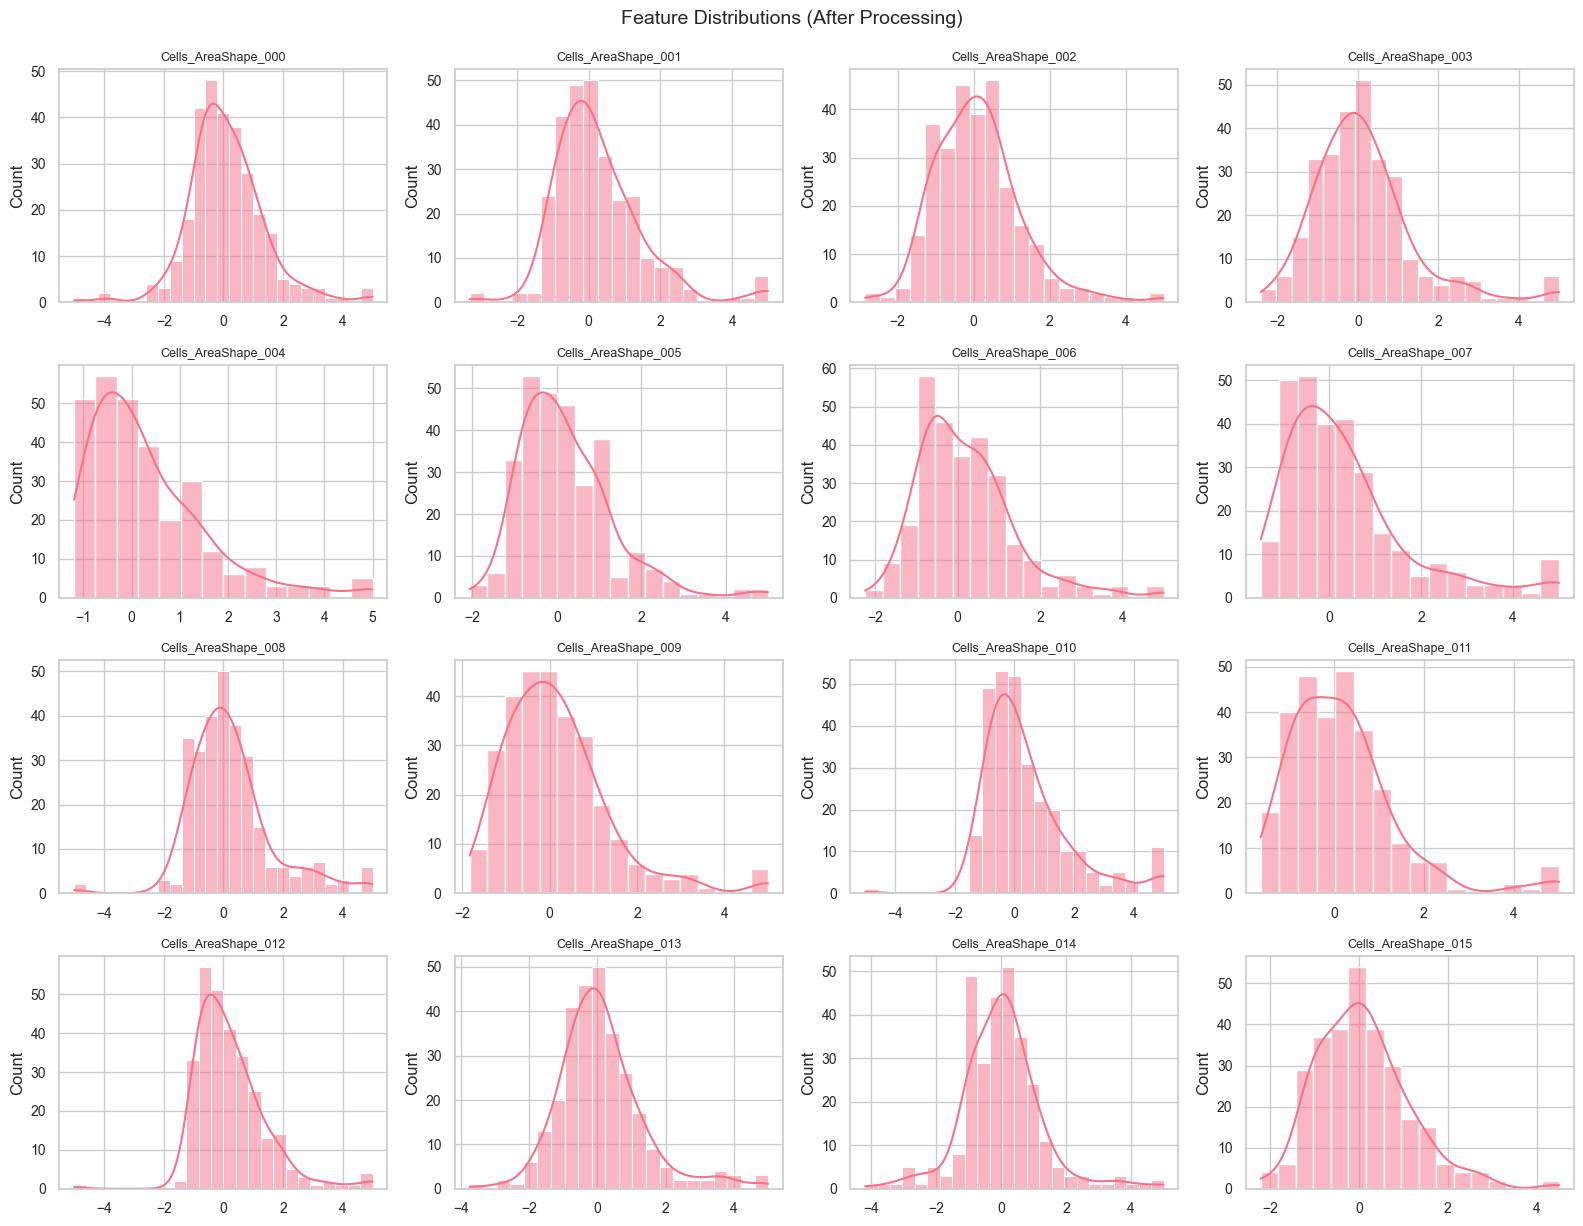

In [34]:
# Plot distributions of selected features
fig, axes = plot_feature_distributions(
    features_final,
    feature_names=selected_feature_names,
    n_features=16,
    figsize=(16, 12),
)
fig.suptitle('Feature Distributions (After Processing)', y=1.02, fontsize=14)
save_figure(fig, FIGURES_DIR / "feature_distributions.png")
plt.show()

### 8.2 Correlation Matrix

2026-02-08 22:22:11 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\correlation_matrix.png


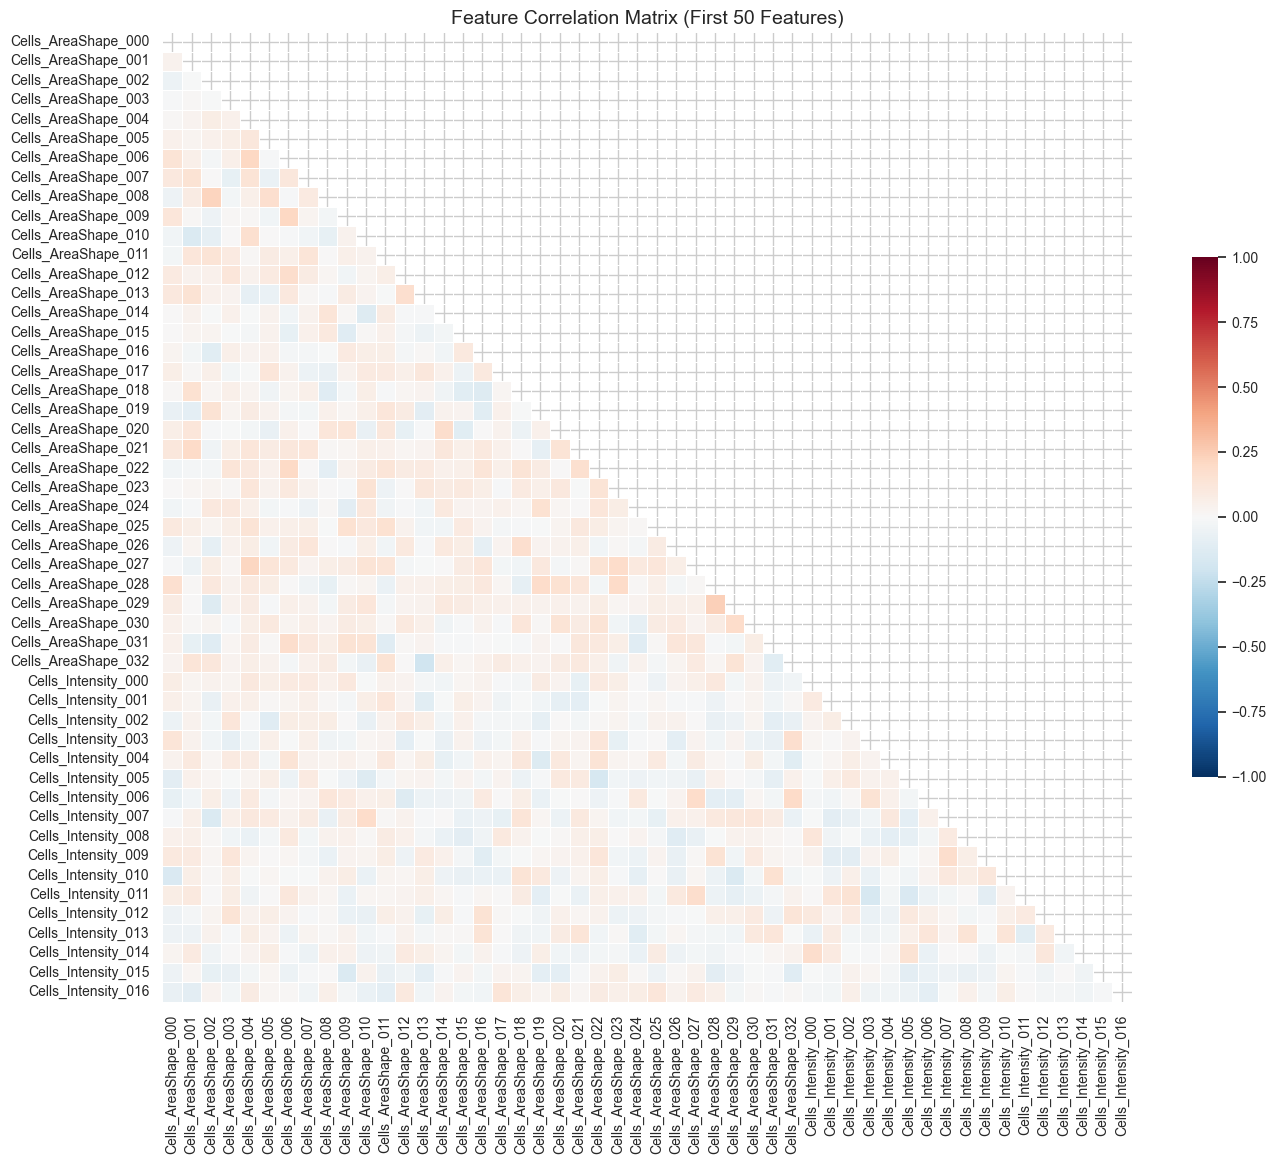

In [35]:
# Plot correlation matrix for a subset of features
n_features_to_plot = 50
feature_subset = features_final[:, :n_features_to_plot]
feature_names_subset = selected_feature_names[:n_features_to_plot]

fig, ax = plot_correlation_matrix(
    feature_subset,
    feature_names=feature_names_subset,
    title="Feature Correlation Matrix (First 50 Features)",
    figsize=(14, 12),
)
save_figure(fig, FIGURES_DIR / "correlation_matrix.png")
plt.show()

### 8.3 UMAP Visualisation

In [36]:
# Generate UMAP embedding
print("Computing UMAP embedding...")
umap_coords = get_umap_embedding(
    features_final,
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
)
print(f"UMAP coordinates shape: {umap_coords.shape}")

2026-02-08 22:22:11 | INFO     | protophen.phenotype.embedding:__init__:129 | Initialised PhenotypeEmbedder: method=umap, n_components=2


Computing UMAP embedding...


c:\Users\adou0002\protophen\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
2026-02-08 22:22:18 | INFO     | protophen.phenotype.embedding:fit_transform:244 | Fitted and transformed with UMAP


UMAP coordinates shape: (288, 2)


2026-02-08 22:22:18 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\umap_treatment.png


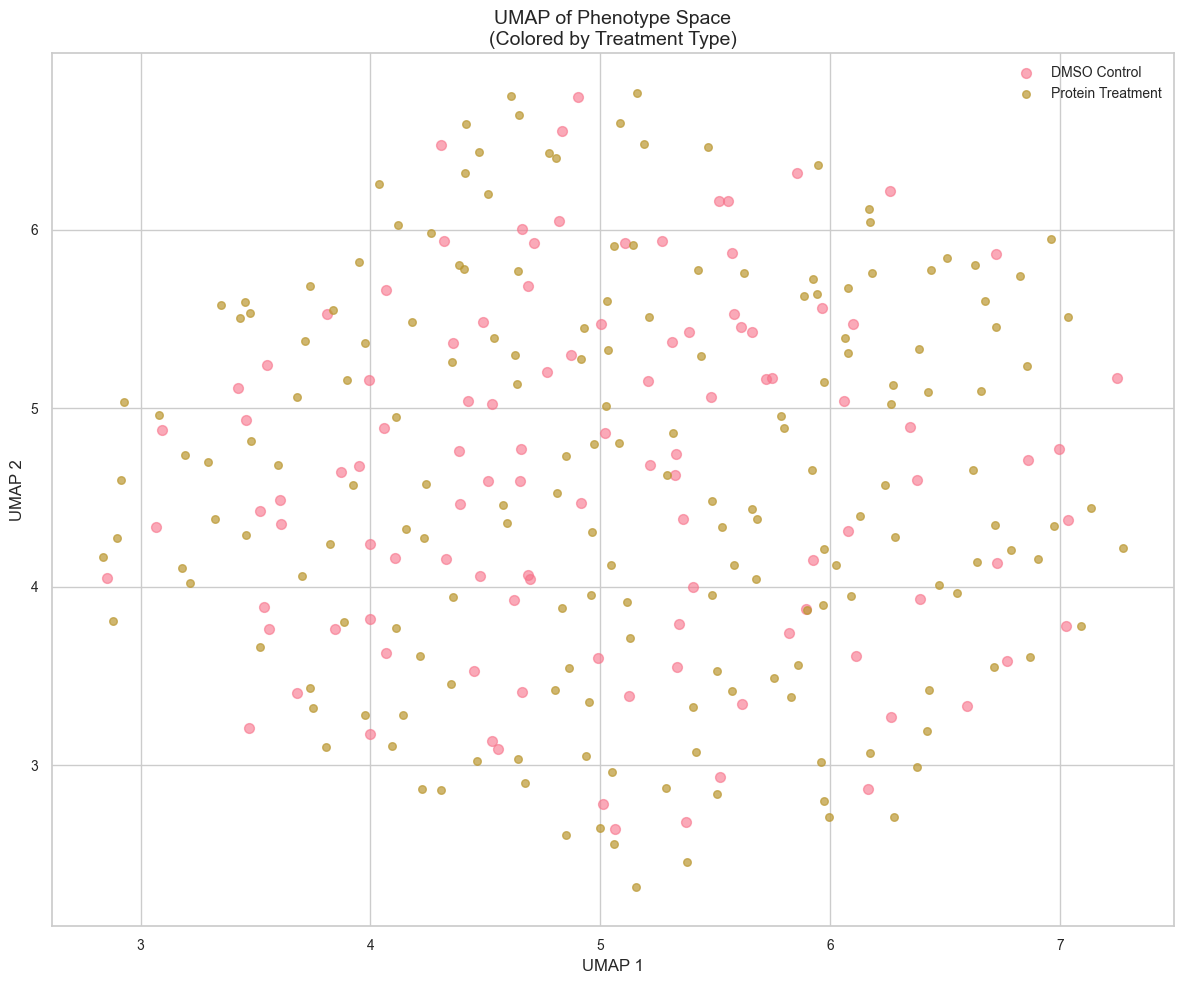

In [37]:
# Plot UMAP colored by treatment
treatment_labels = metadata_df['treatment'].values

# Create treatment categories (group proteins for clarity)
treatment_categories = np.where(
    treatment_labels == 'DMSO',
    'DMSO Control',
    'Protein Treatment'
)

fig, ax = plt.subplots(figsize=(12, 10))

for category in np.unique(treatment_categories):
    mask = treatment_categories == category
    ax.scatter(
        umap_coords[mask, 0],
        umap_coords[mask, 1],
        label=category,
        alpha=0.6 if category == 'DMSO Control' else 0.7,
        s=50 if category == 'DMSO Control' else 30,
    )

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('UMAP of Phenotype Space\n(Colored by Treatment Type)')
ax.legend()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "umap_treatment.png")
plt.show()

c:\Users\adou0002\protophen\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
2026-02-08 22:22:19 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\umap_plate.png


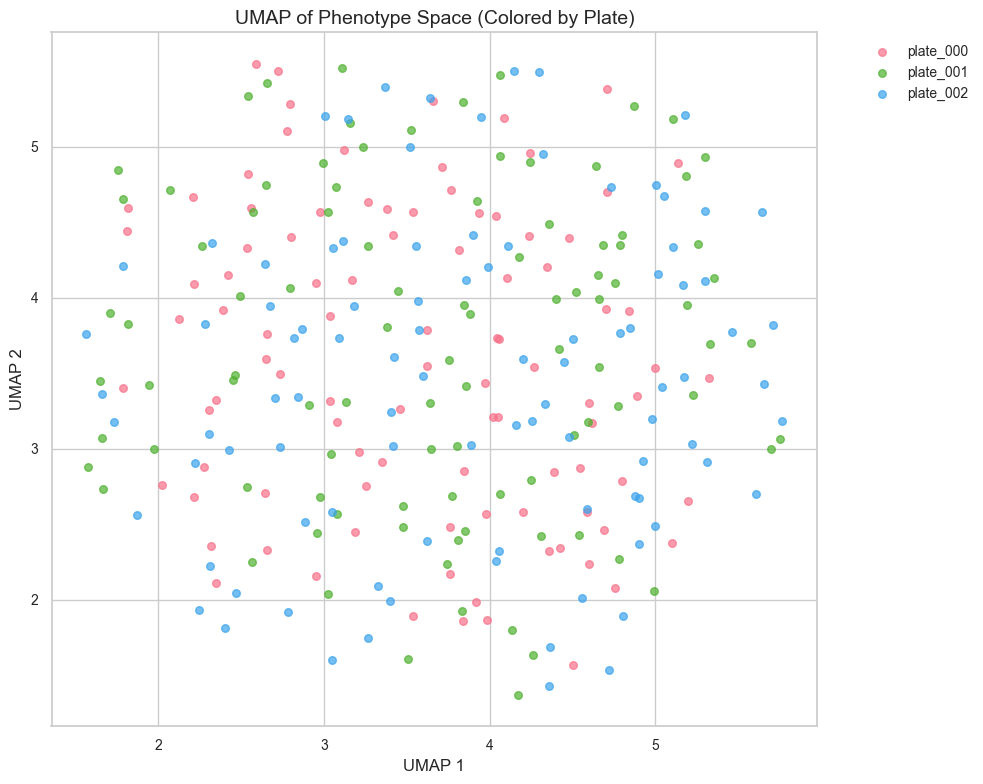

In [38]:
# Plot UMAP colored by plate
fig, ax = plot_embedding_space(
    features_final,
    labels=plate_labels,
    method="umap",
    title="UMAP of Phenotype Space (Colored by Plate)",
)
save_figure(fig, FIGURES_DIR / "umap_plate.png")
plt.show()

### 8.4 t-SNE Visualisation

Computing t-SNE embedding (this may take a moment)...


2026-02-08 22:22:26 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\tsne_treatment.png


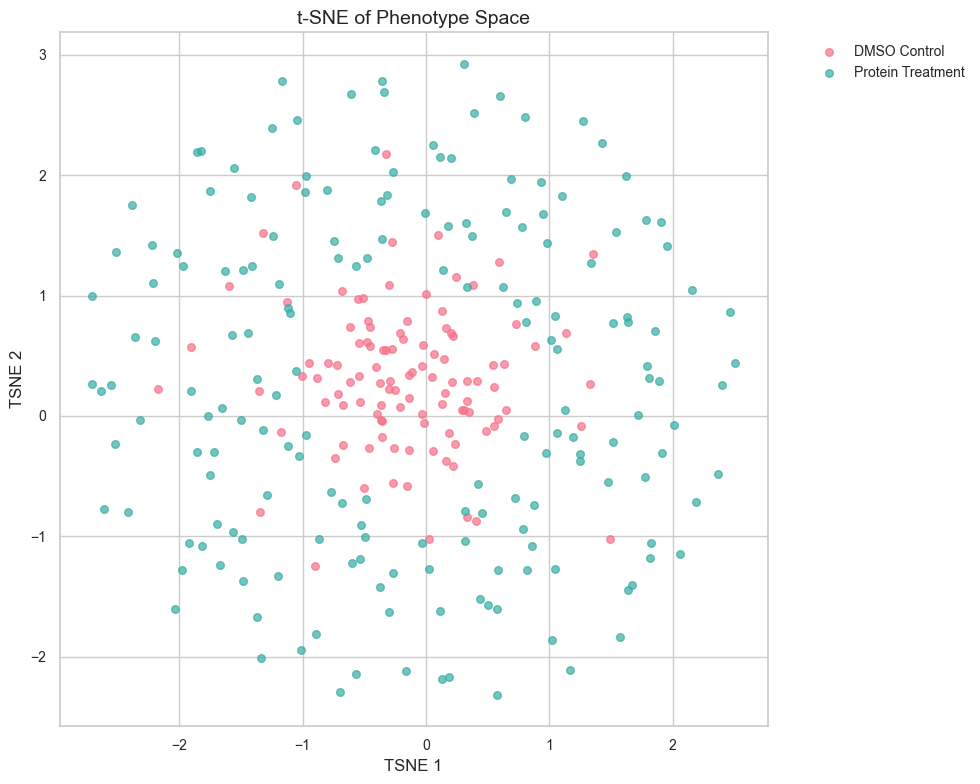

In [39]:
# Generate t-SNE embedding
print("Computing t-SNE embedding (this may take a moment)...")
fig, ax = plot_tsne(
    features_final,
    labels=treatment_categories,
    title="t-SNE of Phenotype Space",
    perplexity=30,
)
save_figure(fig, FIGURES_DIR / "tsne_treatment.png")
plt.show()

### 8.5 PCA Analysis and Explained Variance

2026-02-08 22:22:26 | INFO     | protophen.phenotype.embedding:__init__:129 | Initialised PhenotypeEmbedder: method=pca, n_components=50
2026-02-08 22:22:27 | INFO     | protophen.phenotype.embedding:fit_transform:244 | Fitted and transformed with PCA
2026-02-08 22:22:27 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\pca_variance.png


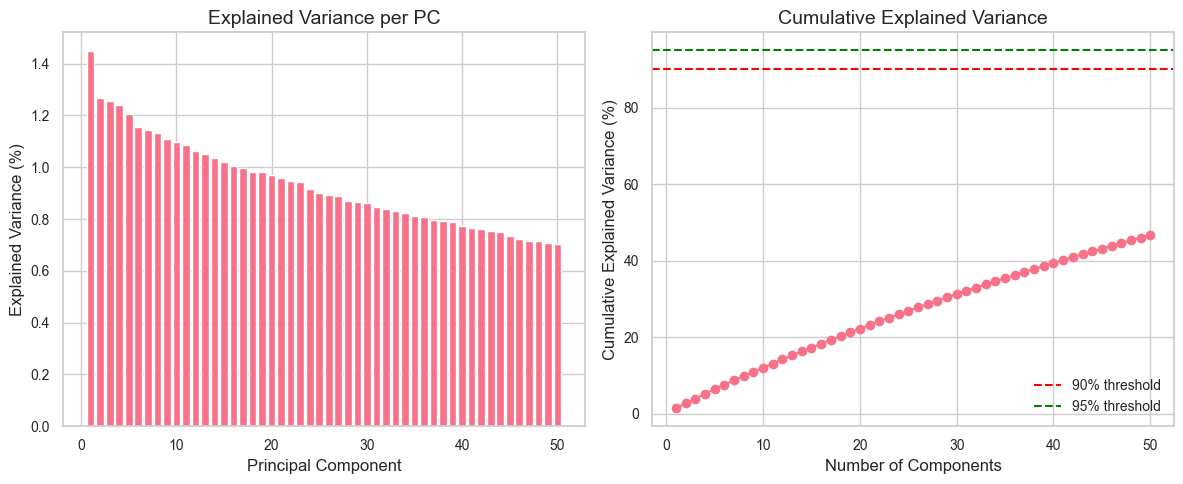

Components for 90% variance: 1
Components for 95% variance: 1


In [40]:
# Perform PCA with more components to analyse variance
pca_full = PhenotypeEmbedder(method="pca", n_components=min(50, features_final.shape[1]))
pca_coords = pca_full.fit_transform(features_final)

# Get explained variance
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Individual variance
axes[0].bar(range(1, len(explained_var) + 1), explained_var * 100)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('Explained Variance per PC')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var * 100, 'o-')
axes[1].axhline(y=90, color='r', linestyle='--', label='90% threshold')
axes[1].axhline(y=95, color='g', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "pca_variance.png")
plt.show()

# Find number of components for 90% and 95% variance
n_90 = np.argmax(cumulative_var >= 0.90) + 1
n_95 = np.argmax(cumulative_var >= 0.95) + 1
print(f"Components for 90% variance: {n_90}")
print(f"Components for 95% variance: {n_95}")

### 8.6 Heatmaps and Clustermaps

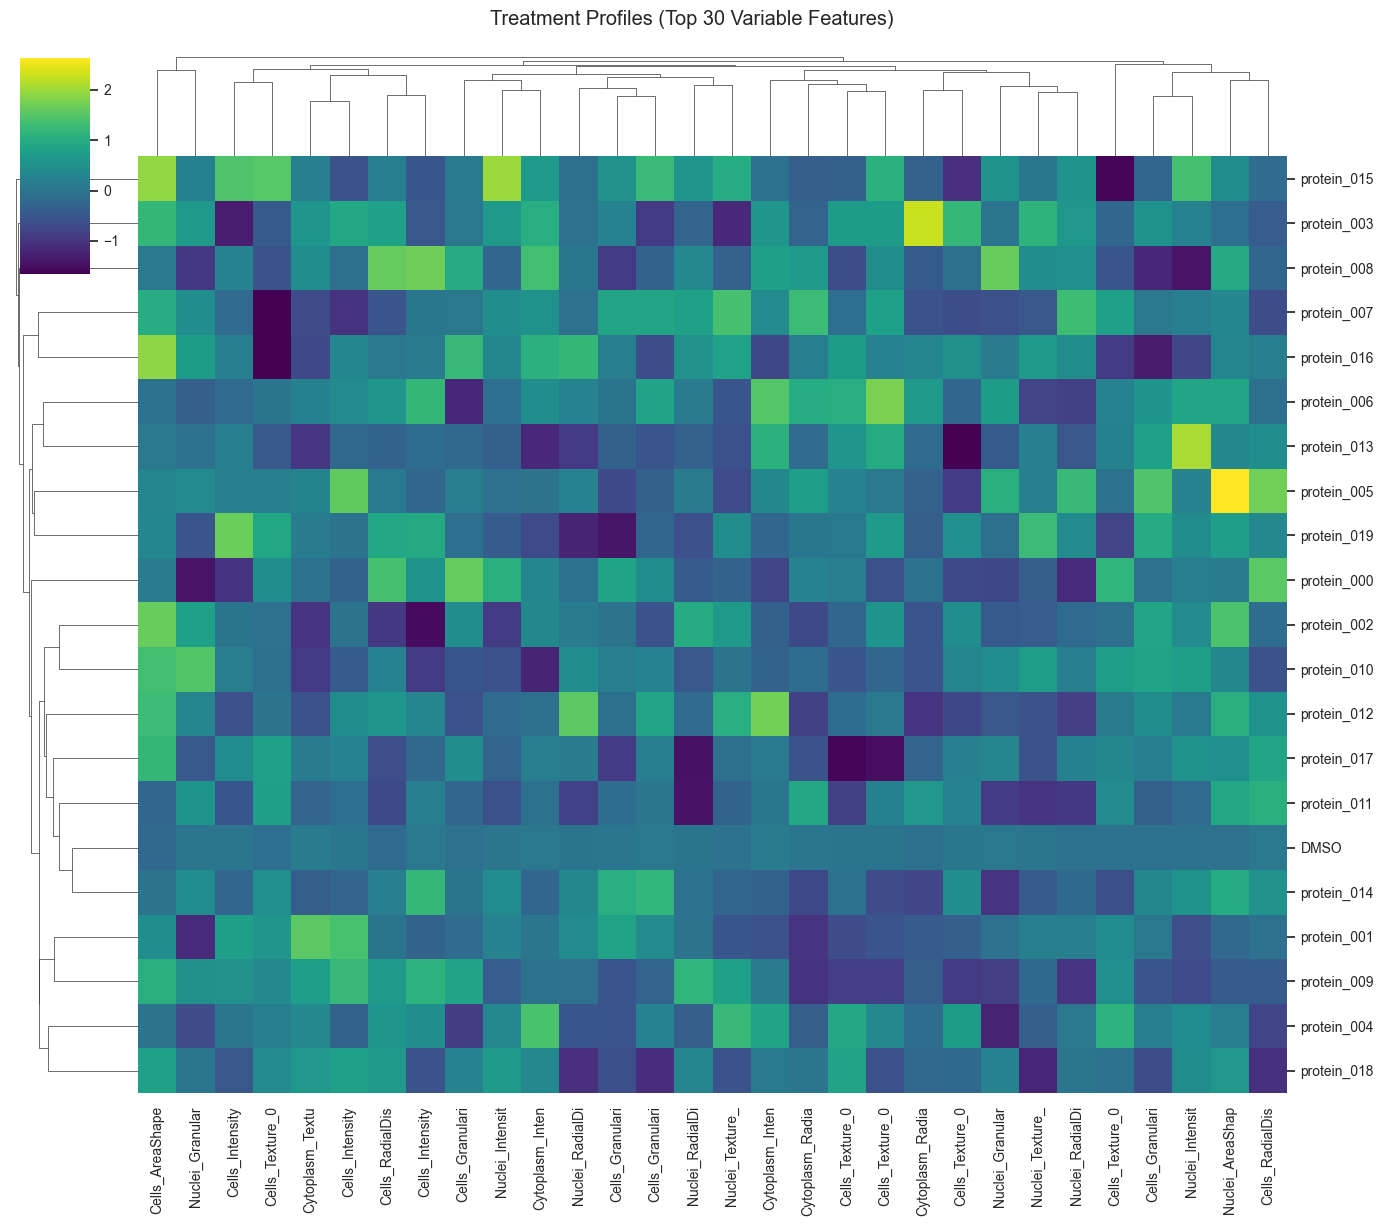

In [41]:
# Create a heatmap of mean features per treatment
treatments = metadata_df['treatment'].unique()
treatment_profiles = []

for treatment in treatments:
    mask = metadata_df['treatment'] == treatment
    mean_profile = features_final[mask.values].mean(axis=0)
    treatment_profiles.append(mean_profile)

treatment_profiles = np.array(treatment_profiles)

# Select top variable features for visualisation
feature_vars = np.var(treatment_profiles, axis=0)
top_features_idx = np.argsort(feature_vars)[-30:]  # Top 30 variable features

# Plot clustermap
g = plot_clustermap(
    treatment_profiles[:, top_features_idx],
    row_labels=treatments.tolist(),
    col_labels=[selected_feature_names[i][:15] for i in top_features_idx],
    title="Treatment Profiles (Top 30 Variable Features)",
    figsize=(14, 12),
)
g.savefig(FIGURES_DIR / "treatment_clustermap.png", dpi=150, bbox_inches='tight')
plt.show()

## 9. Clustering Phenotypes

Clustering identifies groups of samples with similar phenotypic profiles.

### 9.1 Hierarchical Clustering

In [42]:
# Perform hierarchical clustering
sample_ids = metadata_df['sample_id'].tolist()

hierarchical_result = hierarchical_clustering(
    features_final,
    n_clusters=5,
    method="ward",
    sample_ids=sample_ids,
)

print(hierarchical_result.summary())

Clustering Result (hierarchical_ward)
  N clusters: 5
  Cluster sizes: {0: 108, 1: 47, 2: 23, 3: 40, 4: 70}
  Silhouette score: 0.0308
  Calinski-Harabasz: 2.57
  Davies-Bouldin: 7.5561


2026-02-08 22:22:28 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\hierarchical_clusters_umap.png


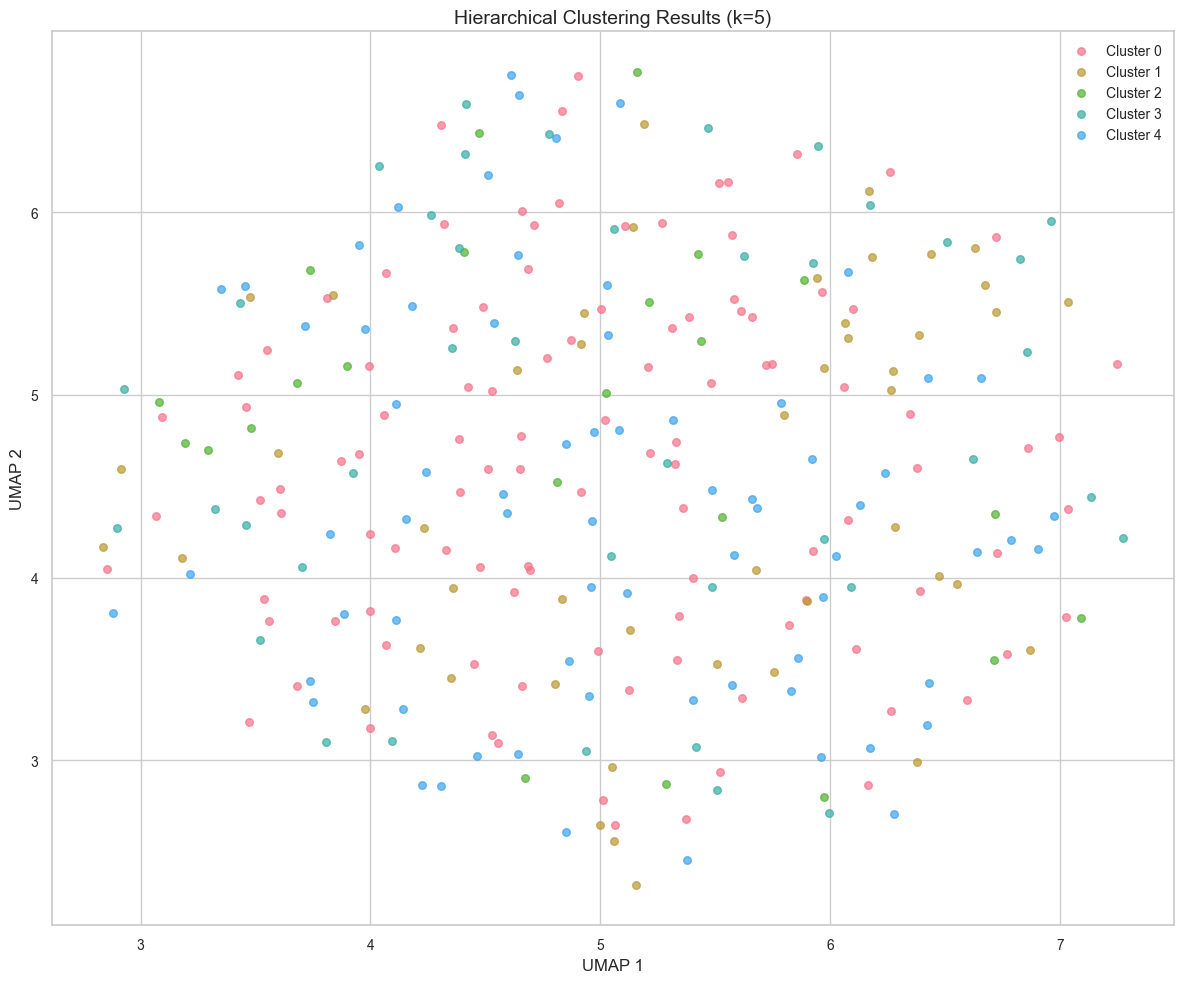

In [43]:
# Visualise clusters in UMAP space
fig, ax = plt.subplots(figsize=(12, 10))

for cluster_id in range(hierarchical_result.n_clusters):
    mask = hierarchical_result.labels == cluster_id
    ax.scatter(
        umap_coords[mask, 0],
        umap_coords[mask, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        s=30,
    )

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title(f'Hierarchical Clustering Results (k={hierarchical_result.n_clusters})')
ax.legend()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "hierarchical_clusters_umap.png")
plt.show()

### 9.2 K-Means Clustering

In [44]:
# Perform k-means clustering
kmeans_result = kmeans_clustering(
    features_final,
    n_clusters=5,
    random_state=RANDOM_STATE,
    sample_ids=sample_ids,
)

print(kmeans_result.summary())

Clustering Result (kmeans)
  N clusters: 5
  Cluster sizes: {0: 77, 1: 1, 2: 144, 3: 65, 4: 1}
  Silhouette score: 0.0665
  Calinski-Harabasz: 2.13
  Davies-Bouldin: 5.7008


In [45]:
# Compare cluster assignments
print("\nCluster Size Comparison:")
print(f"Hierarchical: {hierarchical_result.cluster_sizes}")
print(f"K-Means: {kmeans_result.cluster_sizes}")


Cluster Size Comparison:
Hierarchical: {0: 108, 1: 47, 2: 23, 3: 40, 4: 70}
K-Means: {0: 77, 1: 1, 2: 144, 3: 65, 4: 1}


### 9.3 HDBSCAN Clustering

In [46]:
# HDBSCAN automatically determines number of clusters
try:
    hdbscan_result = hdbscan_clustering(
        features_final,
        min_cluster_size=10,
        min_samples=5,
        sample_ids=sample_ids,
    )
    print(hdbscan_result.summary())
    print(f"Noise points: {hdbscan_result.metadata.get('n_noise_points', 0)}")
except ImportError:
    print("HDBSCAN not available. Install with: pip install hdbscan")
    hdbscan_result = None

Clustering Result (hdbscan)
  N clusters: 0
  Cluster sizes: {-1: 288}
Noise points: 288


### 9.4 Finding Optimal Number of Clusters

In [47]:
# Use PhenotypeClustering to find optimal k
clustering = PhenotypeClustering(method="kmeans")

optimal_k = clustering.find_optimal_k(
    features_final,
    k_range=(2, 15),
    criterion="silhouette",
)

print(f"Optimal number of clusters: {optimal_k}")

2026-02-08 22:22:31 | INFO     | protophen.analysis.clustering:find_optimal_k:461 | Optimal k=2 (criterion=silhouette)


Optimal number of clusters: 2


2026-02-08 22:22:32 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\clustering_metrics.png


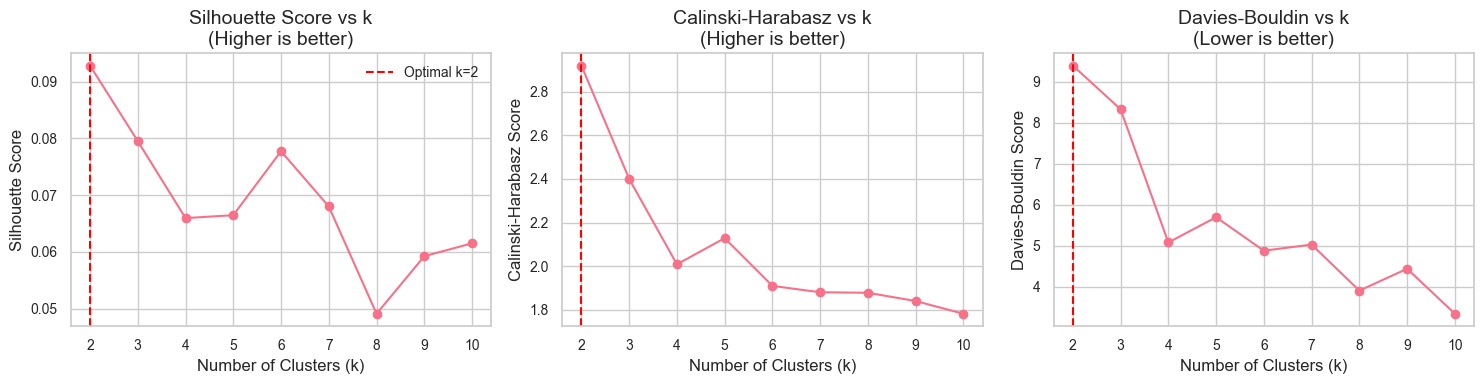

In [48]:
# Evaluate different k values
k_range = range(2, 11)
silhouette_scores = []
calinski_scores = []
davies_scores = []

for k in k_range:
    result = kmeans_clustering(features_final, n_clusters=k, random_state=RANDOM_STATE)
    silhouette_scores.append(result.silhouette)
    calinski_scores.append(result.calinski_harabasz)
    davies_scores.append(result.davies_bouldin)

# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(k_range, silhouette_scores, 'o-')
axes[0].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score vs k\n(Higher is better)')
axes[0].legend()

axes[1].plot(k_range, calinski_scores, 'o-')
axes[1].axvline(x=optimal_k, color='r', linestyle='--')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Calinski-Harabasz Score')
axes[1].set_title('Calinski-Harabasz vs k\n(Higher is better)')

axes[2].plot(k_range, davies_scores, 'o-')
axes[2].axvline(x=optimal_k, color='r', linestyle='--')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].set_title('Davies-Bouldin vs k\n(Lower is better)')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "clustering_metrics.png")
plt.show()

### 9.5 Final Clustering with Optimal k

In [49]:
# Perform final clustering with optimal k
final_clustering = PhenotypeClustering(method="kmeans")
final_result = final_clustering.fit(
    features_final,
    sample_ids=sample_ids,
    n_clusters=optimal_k,
)

print(final_result.summary())

2026-02-08 22:22:33 | INFO     | protophen.analysis.clustering:fit:411 | Clustering Result (kmeans)
  N clusters: 2
  Cluster sizes: {0: 96, 1: 192}
  Silhouette score: 0.0928
  Calinski-Harabasz: 2.92
  Davies-Bouldin: 9.3988


Clustering Result (kmeans)
  N clusters: 2
  Cluster sizes: {0: 96, 1: 192}
  Silhouette score: 0.0928
  Calinski-Harabasz: 2.92
  Davies-Bouldin: 9.3988


2026-02-08 22:22:33 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\final_clusters.png


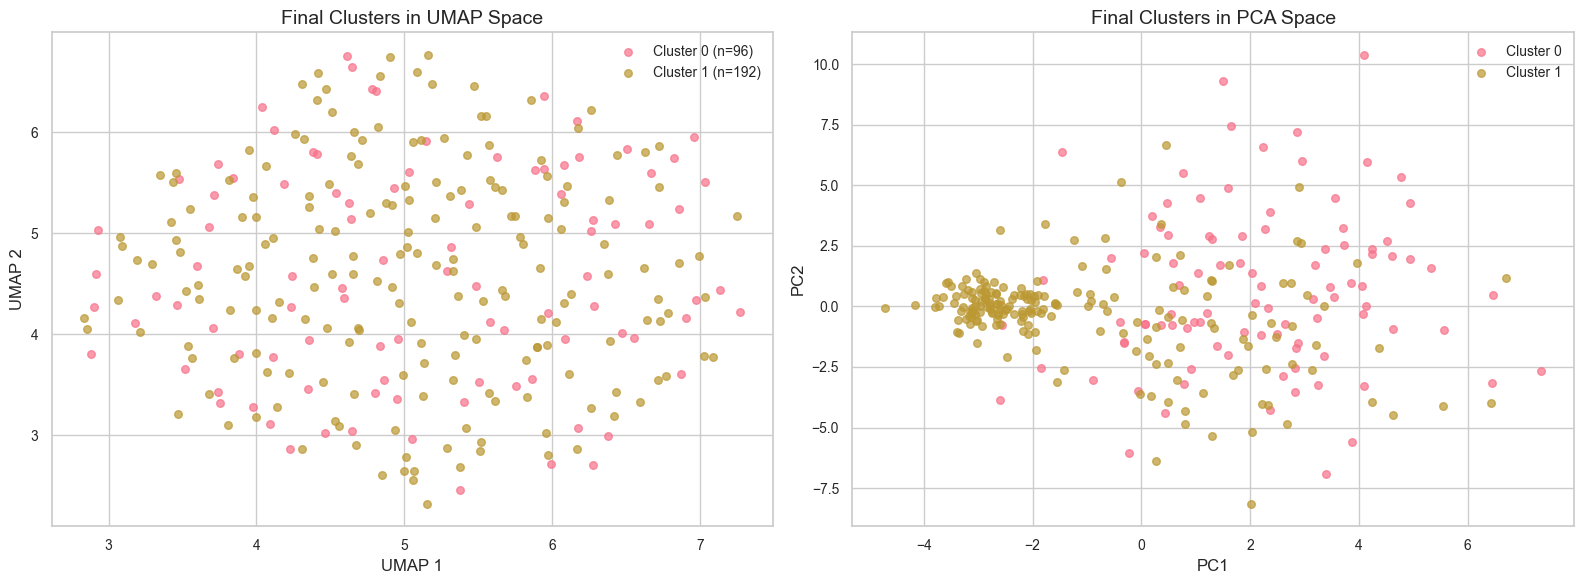

In [50]:
# Visualise final clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# UMAP
for cluster_id in range(final_result.n_clusters):
    mask = final_result.labels == cluster_id
    axes[0].scatter(
        umap_coords[mask, 0],
        umap_coords[mask, 1],
        label=f'Cluster {cluster_id} (n={mask.sum()})',
        alpha=0.7,
        s=30,
    )
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].set_title('Final Clusters in UMAP Space')
axes[0].legend()

# PCA
pca_2d = pca_coords[:, :2]
for cluster_id in range(final_result.n_clusters):
    mask = final_result.labels == cluster_id
    axes[1].scatter(
        pca_2d[mask, 0],
        pca_2d[mask, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        s=30,
    )
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('Final Clusters in PCA Space')
axes[1].legend()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "final_clusters.png")
plt.show()

### 9.6 Cluster Enrichment Analysis

In [51]:
# Prepare annotations for enrichment analysis
# Group samples by treatment type
annotations = {
    'DMSO_controls': [sid for sid, treat in zip(sample_ids, treatment_labels) 
                     if treat == 'DMSO'],
}

# Add some protein families (synthetic groupings)
for i in range(4):
    protein_group = [sid for sid, treat in zip(sample_ids, treatment_labels)
                    if treat != 'DMSO' and int(treat.split('_')[1]) % 4 == i]
    annotations[f'protein_group_{i}'] = protein_group

# Compute enrichment
enrichment = compute_cluster_enrichment(final_result, annotations)

# Display enrichment results
print("Cluster Enrichment Analysis:")
print("=" * 60)

for cluster_id, cluster_enrichment in enrichment.items():
    print(f"\nCluster {cluster_id}:")
    for annotation, stats in cluster_enrichment.items():
        if stats['pvalue'] < 0.1:  # Show significant or near-significant
            print(f"  {annotation}:")
            print(f"    p-value: {stats['pvalue']:.4f}")
            print(f"    odds ratio: {stats['odds_ratio']:.2f}")
            print(f"    count: {stats['count']} (expected: {stats['expected']:.1f})")

Cluster Enrichment Analysis:

Cluster 0:
  DMSO_controls:
    p-value: 0.0000
    odds ratio: 0.00
    count: 0 (expected: 36.0)
  protein_group_0:
    p-value: 0.0092
    odds ratio: 2.43
    count: 23 (expected: 15.0)
  protein_group_1:
    p-value: 0.0003
    odds ratio: 3.38
    count: 26 (expected: 15.0)
  protein_group_2:
    p-value: 0.0092
    odds ratio: 2.43
    count: 23 (expected: 15.0)
  protein_group_3:
    p-value: 0.0031
    odds ratio: 2.71
    count: 24 (expected: 15.0)

Cluster 1:
  DMSO_controls:
    p-value: 0.0000
    odds ratio: inf
    count: 108 (expected: 72.0)
  protein_group_0:
    p-value: 0.0092
    odds ratio: 0.41
    count: 22 (expected: 30.0)
  protein_group_1:
    p-value: 0.0003
    odds ratio: 0.30
    count: 19 (expected: 30.0)
  protein_group_2:
    p-value: 0.0092
    odds ratio: 0.41
    count: 22 (expected: 30.0)
  protein_group_3:
    p-value: 0.0031
    odds ratio: 0.37
    count: 21 (expected: 30.0)


### 9.7 Cluster Profiles

2026-02-08 22:22:34 | INFO     | protophen.analysis.visualisation:save_figure:805 | Saved figure to outputs\02_phenotype_exploration\figures\cluster_profiles.png


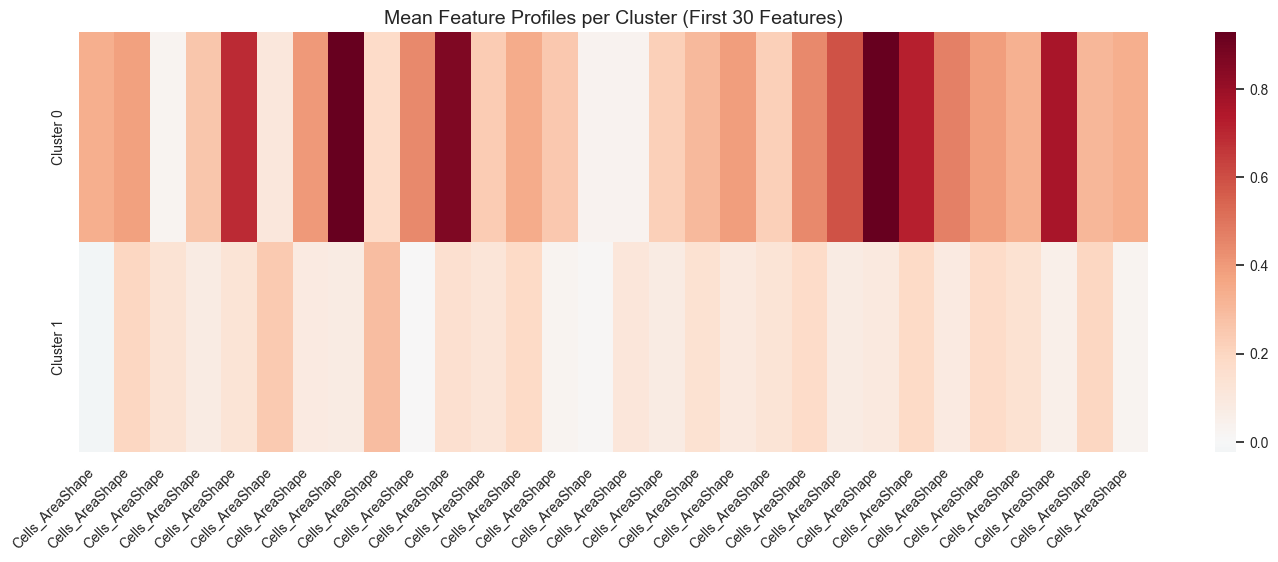

In [52]:
# Get mean profiles per cluster
cluster_profiles = final_clustering.get_cluster_profiles(
    features_final,
    feature_names=selected_feature_names,
)

# Create heatmap of cluster profiles
profile_matrix = np.array([
    [cluster_profiles[c][f] for f in selected_feature_names[:30]]
    for c in range(final_result.n_clusters)
])

fig, ax = plot_heatmap(
    profile_matrix,
    row_labels=[f'Cluster {i}' for i in range(final_result.n_clusters)],
    col_labels=[f[:15] for f in selected_feature_names[:30]],
    title='Mean Feature Profiles per Cluster (First 30 Features)',
    center=0,
    figsize=(14, 6),
)
plt.xticks(rotation=45, ha='right')
save_figure(fig, FIGURES_DIR / "cluster_profiles.png")
plt.show()

## 10. Saving Processed Data

Save the processed data for use in model training.

### 10.1 Save Processed Features

In [53]:
# Create a comprehensive output DataFrame
output_df = metadata_df.copy()

# Add cluster assignments
output_df['cluster'] = final_result.labels

# Add UMAP coordinates
output_df['umap_1'] = umap_coords[:, 0]
output_df['umap_2'] = umap_coords[:, 1]

# Add PCA coordinates
output_df['pc_1'] = pca_coords[:, 0]
output_df['pc_2'] = pca_coords[:, 1]

# Save metadata
output_df.to_csv(DATA_DIR / "processed_metadata.csv", index=False)
print(f"Saved metadata to: {DATA_DIR / 'processed_metadata.csv'}")

Saved metadata to: outputs\02_phenotype_exploration\processed_data\processed_metadata.csv


In [54]:
# Save processed feature matrix
np.save(DATA_DIR / "processed_features.npy", features_final)
print(f"Saved features to: {DATA_DIR / 'processed_features.npy'}")
print(f"Shape: {features_final.shape}")

Saved features to: outputs\02_phenotype_exploration\processed_data\processed_features.npy
Shape: (288, 495)


In [55]:
# Save feature names
import json
with open(DATA_DIR / "feature_names.json", 'w') as f:
    json.dump(selected_feature_names, f, indent=2)
print(f"Saved feature names to: {DATA_DIR / 'feature_names.json'}")

Saved feature names to: outputs\02_phenotype_exploration\processed_data\feature_names.json


### 10.2 Save Embeddings for Model Training

In [56]:
# Create embeddings dictionary for integration with protein embeddings
phenotype_embeddings = {}
for i, sample_id in enumerate(sample_ids):
    phenotype_embeddings[sample_id] = features_final[i]

save_embeddings(phenotype_embeddings, DATA_DIR / "phenotype_embeddings.pkl.gz")
print(f"Saved phenotype embeddings to: {DATA_DIR / 'phenotype_embeddings.pkl.gz'}")

Saved phenotype embeddings to: outputs\02_phenotype_exploration\processed_data\phenotype_embeddings.pkl.gz


### 10.3 Save Clustering Results

In [57]:
# Save clustering results
clustering_output = {
    'labels': final_result.labels.tolist(),
    'n_clusters': final_result.n_clusters,
    'method': final_result.method,
    'silhouette': final_result.silhouette,
    'cluster_sizes': final_result.cluster_sizes,
    'sample_ids': sample_ids,
}

with open(DATA_DIR / "clustering_results.json", 'w') as f:
    json.dump(clustering_output, f, indent=2)
print(f"Saved clustering results to: {DATA_DIR / 'clustering_results.json'}")

Saved clustering results to: outputs\02_phenotype_exploration\processed_data\clustering_results.json


### 10.4 Save Processing Configuration

In [58]:
# Save the processing configuration for reproducibility
processing_config = {
    'feature_selection': {
        'min_variance': selector.min_variance,
        'max_correlation': selector.max_correlation,
        'max_nan_fraction': selector.max_nan_fraction,
        'n_original_features': feature_matrix.shape[1],
        'n_selected_features': selector.n_selected_,
    },
    'batch_correction': {
        'method': batch_corrector.method,
    },
    'normalisation': {
        'method': 'robust_mad',
        'clip_outliers': True,
        'outlier_threshold': 5.0,
    },
    'clustering': {
        'method': 'kmeans',
        'n_clusters': optimal_k,
        'criterion': 'silhouette',
    },
    'random_state': RANDOM_STATE,
}

with open(DATA_DIR / "processing_config.json", 'w') as f:
    json.dump(processing_config, f, indent=2)
print(f"Saved processing config to: {DATA_DIR / 'processing_config.json'}")

Saved processing config to: outputs\02_phenotype_exploration\processed_data\processing_config.json


## 11. Summary & Next Steps

### Summary

In this notebook, we demonstrated the complete Cell Painting data processing pipeline:

1. **Data Loading**: Used `CellPaintingProcessor` to load and parse CellProfiler output
2. **Quality Assessment**: Analysed missing values, feature distributions, and identified problematic features
3. **Feature Selection**: Reduced features from ~500 to fewer using variance and correlation filtering
4. **Batch Correction**: Applied robust normalisation to correct plate-level batch effects
5. **Normalisation**: Applied robust MAD normalisation for comparable feature scales
6. **Visualisation**: Created UMAP, t-SNE, PCA, and heatmap visualisations
7. **Clustering**: Identified phenotype clusters using multiple methods
8. **Export**: Saved processed data for model training

### Key Processing Statistics

In [59]:
print("=" * 60)
print("PROCESSING SUMMARY")
print("=" * 60)
print(f"\nData:")
print(f"  Samples: {len(dataset)}")
print(f"  Plates: {len(np.unique(plate_labels))}")
print(f"  Treatments: {len(np.unique(treatment_labels))}")

print(f"\nFeature Selection:")
print(f"  Original features: {feature_matrix.shape[1]}")
print(f"  Selected features: {selector.n_selected_}")
print(f"  Reduction: {100 * selector.n_removed_ / feature_matrix.shape[1]:.1f}%")

print(f"\nClustering:")
print(f"  Method: K-Means")
print(f"  Optimal k: {optimal_k}")
print(f"  Silhouette score: {final_result.silhouette:.4f}")

print(f"\nPCA:")
print(f"  Components for 90% variance: {n_90}")
print(f"  Components for 95% variance: {n_95}")

print(f"\nOutput files saved to: {DATA_DIR}")

PROCESSING SUMMARY

Data:
  Samples: 288
  Plates: 3
  Treatments: 21

Feature Selection:
  Original features: 495
  Selected features: 495
  Reduction: 0.0%

Clustering:
  Method: K-Means
  Optimal k: 2
  Silhouette score: 0.0928

PCA:
  Components for 90% variance: 1
  Components for 95% variance: 1

Output files saved to: outputs\02_phenotype_exploration\processed_data


### Next Steps

With the processed phenotype data, you can now proceed with:

1. **Notebook 03 - Model Training**: Train the ProToPhen model to predict phenotypes from protein embeddings
2. **Notebook 04 - Active Learning**: Use uncertainty quantification to select informative experiments

### Integration with Protein Embeddings

The phenotype embeddings saved in this notebook can be paired with protein embeddings from Notebook 01:

```python
# Load protein embeddings (from Notebook 01)
protein_embeddings = np.load("outputs/01_protein_embeddings/embeddings/fused_embeddings.npy")
protein_ids = open("outputs/01_protein_embeddings/embeddings/protein_ids.txt").read().splitlines()

# Load phenotype embeddings (from this notebook)
phenotype_embeddings = load_embeddings("outputs/02_phenotype_exploration/processed_data/phenotype_embeddings.pkl.gz")

# Create paired dataset for training
paired_data = []
for sample_id, phenotype in phenotype_embeddings.items():
    protein_id = sample_id_to_protein_id[sample_id]  # Your mapping
    if protein_id in protein_embeddings:
        paired_data.append({
            'protein_embedding': protein_embeddings[protein_id],
            'phenotype': phenotype,
        })
```

---